<a href="https://colab.research.google.com/github/TejaNaveenChintapalli/RL_assignment1/blob/main/tejanave_RL_Final_submission_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Assignment 1 </h1>


Checkpoint - 1

In [27]:
from matplotlib.text import Annotation
import numpy as np
import matplotlib.pyplot as plt
import gym
import time
import seaborn as sns
from google.colab import widgets
from gym import spaces
import random
import pickle
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/RL/
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/RL
destination.png
Deterministic_q_table_q_learning_values.pickle
Deterministic_q_table_sarsa_values.pickle
empty.png
gold.png
NVDA.csv
pit.png
Stochastic_q_table_q_learning_values.pickle
Stochastic_q_table_sarsa_values.pickle
Stock_trading_q_table_values.pickle
wumpus.png


#Deterministic Environment

In [28]:
class LawnMowerDeterministicEnvironment(gym.Env):
  metadata = {'render.modes' : []} 
  def __init__(self, n_rows = 4, n_columns = 4, A_pos = [0, 0], G_pos = [3, 3], max_steps = 15):
    self.observation_space = spaces.Discrete(n_rows * n_columns)
    self.n_states = n_rows * n_columns
    self.n_rows = n_rows
    self.n_columns = n_columns
    
    # Possible actions [Up, Right, Down, Left]
    self.action_space = spaces.Discrete(4)
    self.n_actions = 4

    # Initialization of the State
    self.state = np.zeros((n_rows, n_columns))

    # Initial position of the Agent
    self.agent_pos = [element for element in A_pos]
    self.start_pos = [element for element in A_pos]

    # Goal position of the Agent
    self.goal_pos = [element for element in G_pos]

    # Positive Rewards Placement
    self.positive_Reward_Pos = [[3, 2], [2, 1], [3, 3]]
    self.state[tuple(self.positive_Reward_Pos[0])] = 10
    self.state[tuple(self.positive_Reward_Pos[1])] = 14
    self.state[tuple(self.goal_pos)] = 20

    # Negative Rewards Placement
    self.negative_Reward_Pos = [[0, 2], [2, 3]]
    self.state[tuple(self.negative_Reward_Pos[0])] = -15
    self.state[tuple(self.negative_Reward_Pos[1])] = -13
    self.state[tuple(self.agent_pos)] = 1
    self.done = False
    self.total_reward = 0
    self.timestep = 0
    self.max_Timestep = max_steps
    
    
    
  def reset(self):
    # Initialization of the state
    self.state = np.zeros((self.n_rows, self.n_columns))

    # Initial position of agent
    self.agent_pos = [element for element in self.start_pos]

    # Positive Rewards Placement
    self.state[tuple(self.positive_Reward_Pos[0])] = 10
    self.state[tuple(self.positive_Reward_Pos[1])] = 14
    self.state[tuple(self.goal_pos)] = 20

    # Negative Rewards Placement
    self.state[tuple(self.negative_Reward_Pos[0])] = -15
    self.state[tuple(self.negative_Reward_Pos[1])] = -13
    self.state[tuple(self.agent_pos)] = 1
    self.done = False
    self.total_reward = 0
    self.timestep = 0
    
  def clip(self):
    '''clips the position if it goes out of bounds'''
    if self.agent_pos[0] < 0:
      self.agent_pos[0] = 0
    elif self.agent_pos[0] >= self.n_rows:
      self.agent_pos[0] = self.n_rows - 1
    if self.agent_pos[1] < 0:
      self.agent_pos[1] = 0
    elif self.agent_pos[1] >= self.n_columns:
      self.agent_pos[1] = self.n_columns - 1
    pass

  def step(self, action):
    '''
      Input - Action: 0[Up], 1[Right], 2[Down], 3[Left]
      Returns -
        agent_pos - Agent current position after applying the move
        reward - Reward gained by current action
        done - Goal reached status (True/False)
        info - Additional info if any
    '''
    self.state[tuple(self.agent_pos)] = 0

    if action == 0: #Up
      self.agent_pos[0] -= 1
    elif action == 1: #Right
      self.agent_pos[1] += 1
    elif action == 2: #Down
      self.agent_pos[0] += 1
    elif action == 3: #Left
      self.agent_pos[1] -= 1
    
    self.clip()

    cur_reward = self.state[tuple(self.agent_pos)]
    
    self.total_reward += cur_reward
    self.state[tuple(self.agent_pos)] = 1
    self.timestep += 1

    self.done = True if (self.agent_pos == self.goal_pos or self.timestep >= self.max_Timestep) else False
    info = {}
    observation = self.state.flatten()
    return observation, cur_reward, self.done, info
    


  def render(self):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 4)
    def plot_image(plot_pos):
      #print(plot_pos)
      plot_agent, plot_gold, plot_pit, plot_dest = False, False, False, False
      if np.array_equal(self.agent_pos, plot_pos):
        plot_agent = True
      elif np.array_equal(plot_pos, self.goal_pos):
        plot_dest = True
      elif self.state[tuple(plot_pos)] > 0:  # Gold isn't plotted if it has already been picked by one of the agents.
        plot_gold = True
      elif self.state[tuple(plot_pos)] < 0:
        plot_pit = True
      #if any(np.array_equal(self.negative_Reward_Pos[i], plot_pos) for i in range(len(self.negative_Reward_Pos))):
       # plot_pit = True
      #if any(np.array_equal(self.postive_Reward_Pos[i], plot_pos) for i in range(len(self.postive_Reward_Pos))):
       # plot_gold = True
      if plot_agent and all(not item for item in
                        [plot_gold, plot_pit, plot_dest]):
        agent = AnnotationBbox(OffsetImage(plt.imread('wumpus.png'), zoom=0.15),
                                       np.add(plot_pos, [0.5, 0.5]), frameon=False)
        ax.add_artist(agent)
      elif plot_gold and \
                    all(not item for item in
                        [plot_agent, plot_pit, plot_dest]):
                gold = AnnotationBbox(OffsetImage(plt.imread('gold.png'), zoom=0.15),
                                      np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(gold)
      elif plot_pit and \
                    all(not item for item in
                        [plot_gold, plot_agent, plot_dest]):
                pit = AnnotationBbox(OffsetImage(plt.imread('pit.png'), zoom=0.15),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(pit)
      elif plot_dest and \
                    all(not item for item in
                        [plot_gold, plot_pit, plot_agent]):
                pit = AnnotationBbox(OffsetImage(plt.imread('destination.png'), zoom=0.3),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(pit)
      else:
        pit = AnnotationBbox(OffsetImage(plt.imread('empty.png'), zoom=0.25),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
        ax.add_artist(pit)
    coordinates_state_mapping_2 = {}
    for j in range(4 * 4):
        coordinates_state_mapping_2[j] = np.asarray(
            [(j % 4), (int(np.floor(j / 4)))])

    # Rendering the images for all states.
    for position in coordinates_state_mapping_2:
      plot_image(coordinates_state_mapping_2[position])

    plt.xticks([0, 1, 2, 3, 4])
    plt.yticks([0, 1, 2, 3, 4])
    plt.grid()
    plt.show()


In [29]:
def RandomAgent(env):
  map_action = {0: 'Up', 1: 'Right', 2: 'Down', 3: 'Left'}
  for i in range(2):
    print(f"************* Episode {i+1} *************")
    env.reset()
    print("--------------- initial state ---------------")
    print("current state:", env.agent_pos)
    env.render()

    for step in range(0,env.max_Timestep):
      action = env.action_space.sample()
      observation, reward, done, _ = env.step(action)
      print(f"\n--------------- After Timestep {step+1} ---------------")
      print("current state:", env.agent_pos)
      print("chosen action:",  map_action[action])
      print("reward after current step:",  reward)
      print("Total reward:", env.total_reward)
      env.render()
      if done:
        #env.render()
        print(f"\n ************* Episode {i+1} ends, Cumulative Rewards = {env.total_reward} ************* \n")
        print("\n ************* Resetting the environment ************* \n")
        break



************* Episode 1 *************
--------------- initial state ---------------
current state: [0, 0]


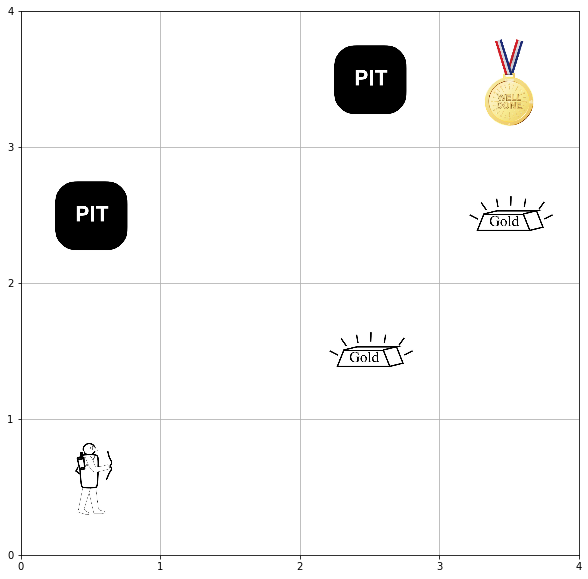


--------------- After Timestep 1 ---------------
current state: [1, 0]
chosen action: Down
reward after current step: 0.0
Total reward: 0.0


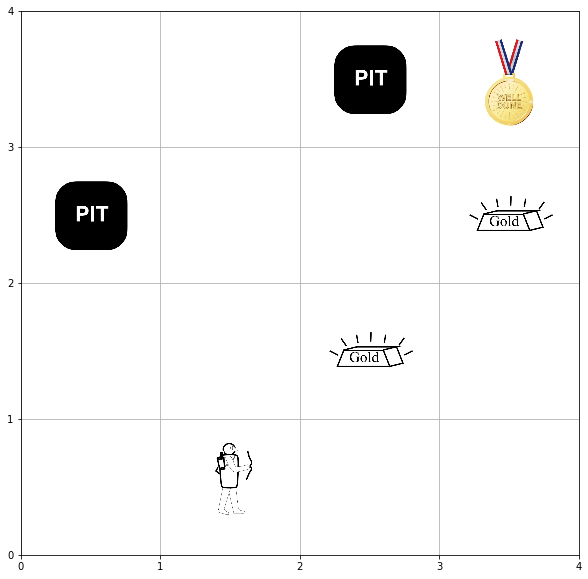


--------------- After Timestep 2 ---------------
current state: [2, 0]
chosen action: Down
reward after current step: 0.0
Total reward: 0.0


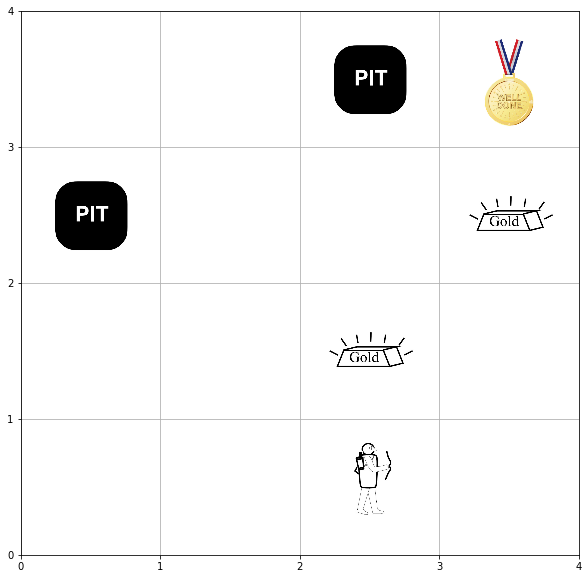


--------------- After Timestep 3 ---------------
current state: [2, 1]
chosen action: Right
reward after current step: 14.0
Total reward: 14.0


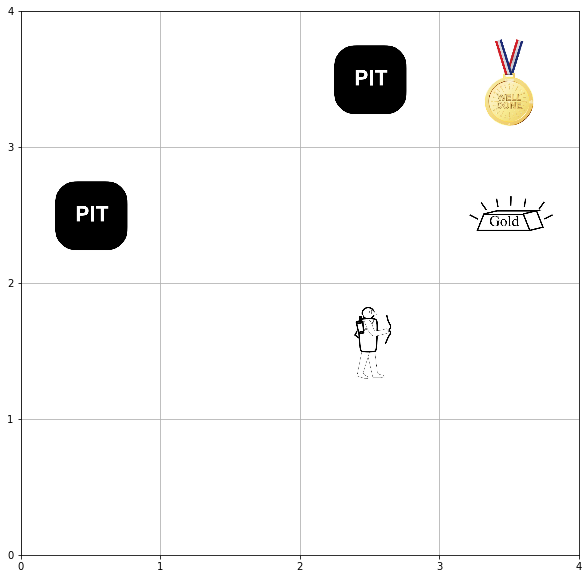


--------------- After Timestep 4 ---------------
current state: [1, 1]
chosen action: Up
reward after current step: 0.0
Total reward: 14.0


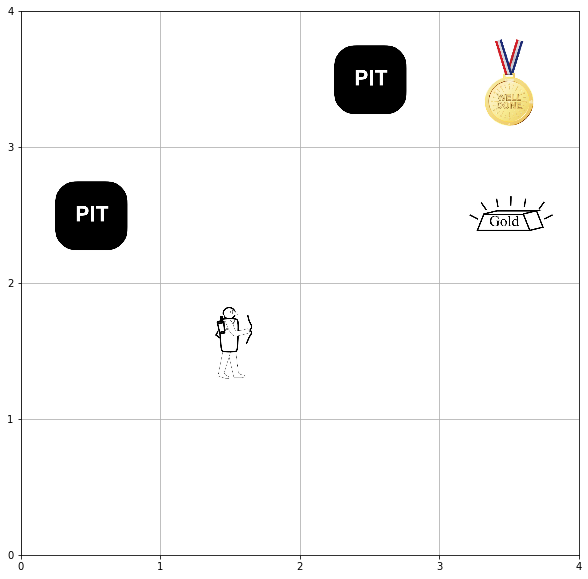


--------------- After Timestep 5 ---------------
current state: [1, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 14.0


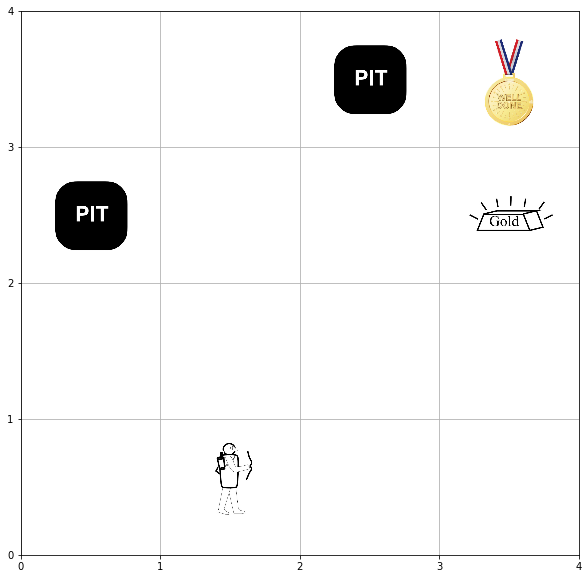


--------------- After Timestep 6 ---------------
current state: [1, 1]
chosen action: Right
reward after current step: 0.0
Total reward: 14.0


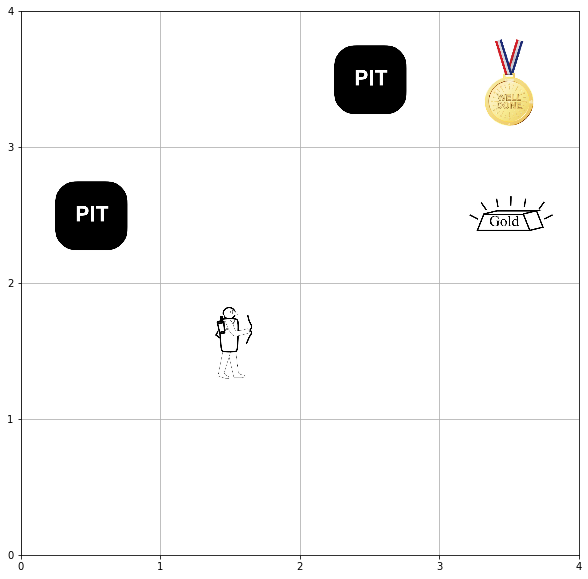


--------------- After Timestep 7 ---------------
current state: [2, 1]
chosen action: Down
reward after current step: 0.0
Total reward: 14.0


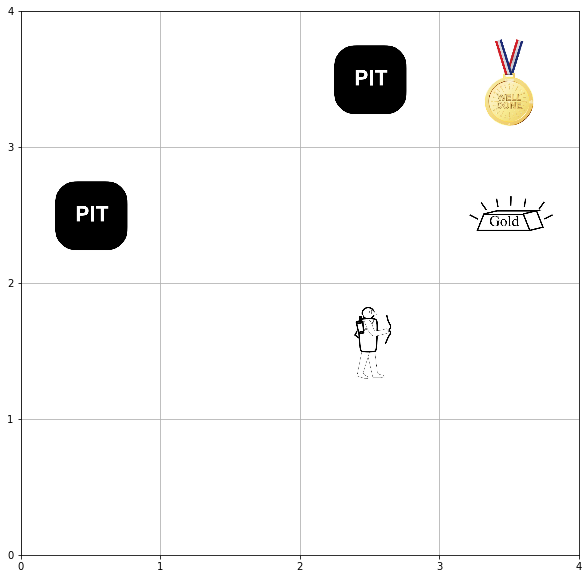


--------------- After Timestep 8 ---------------
current state: [2, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 14.0


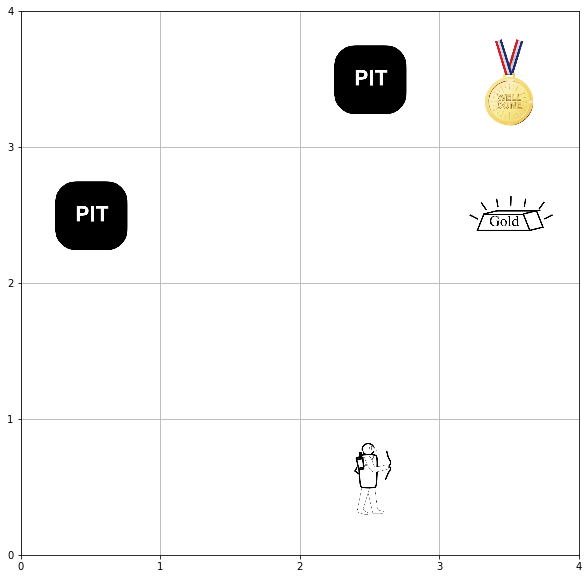


--------------- After Timestep 9 ---------------
current state: [2, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 14.0


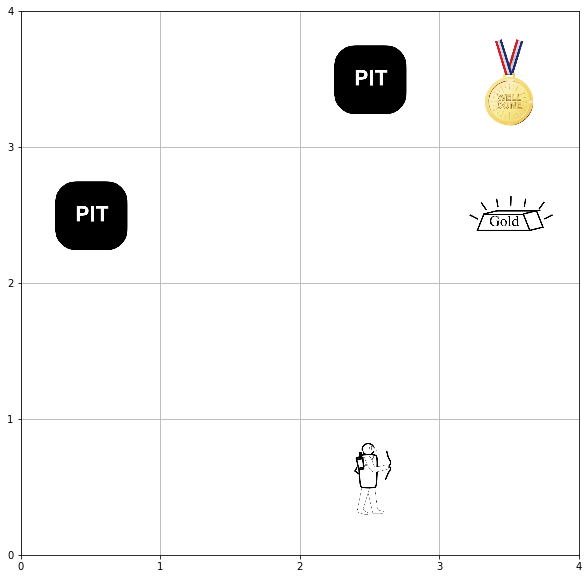


--------------- After Timestep 10 ---------------
current state: [2, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 14.0


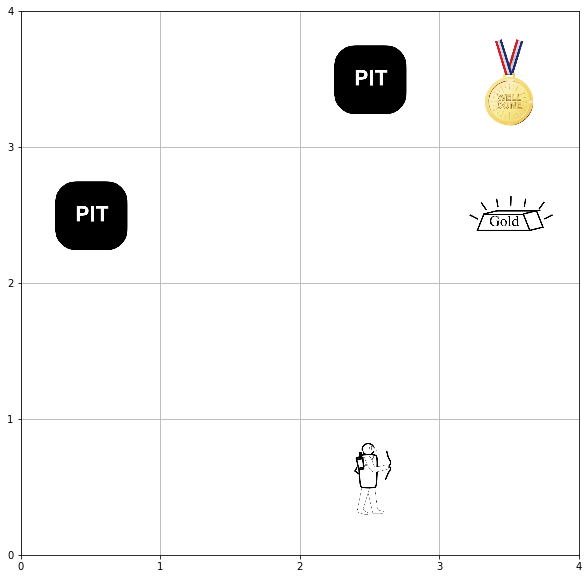


--------------- After Timestep 11 ---------------
current state: [2, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 14.0


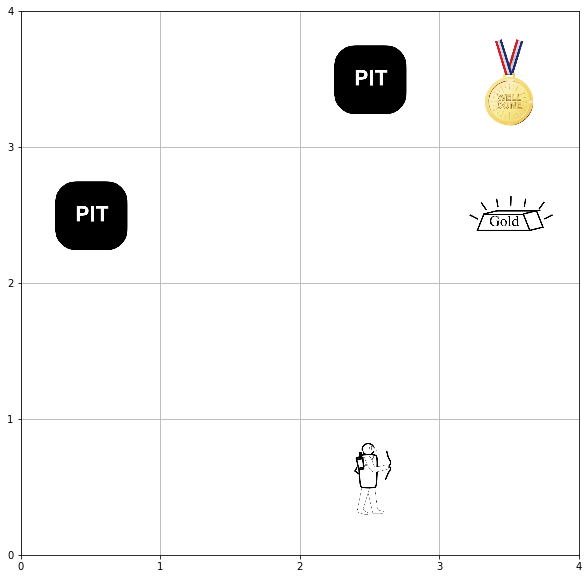


--------------- After Timestep 12 ---------------
current state: [2, 1]
chosen action: Right
reward after current step: 0.0
Total reward: 14.0


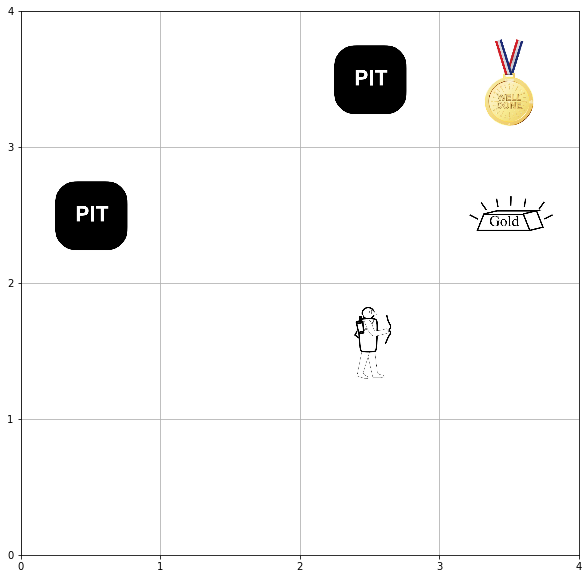


 ************* Episode 1 ends, Cumulative Rewards = 14.0 ************* 


 ************* Resetting the environment ************* 

************* Episode 2 *************
--------------- initial state ---------------
current state: [0, 0]


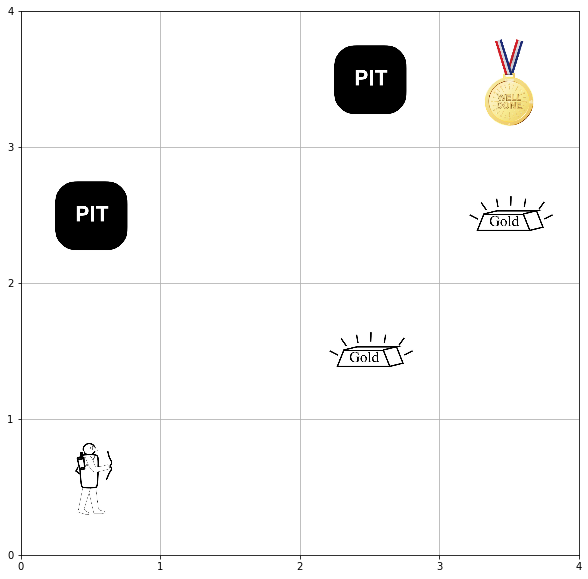


--------------- After Timestep 1 ---------------
current state: [0, 0]
chosen action: Up
reward after current step: 0.0
Total reward: 0.0


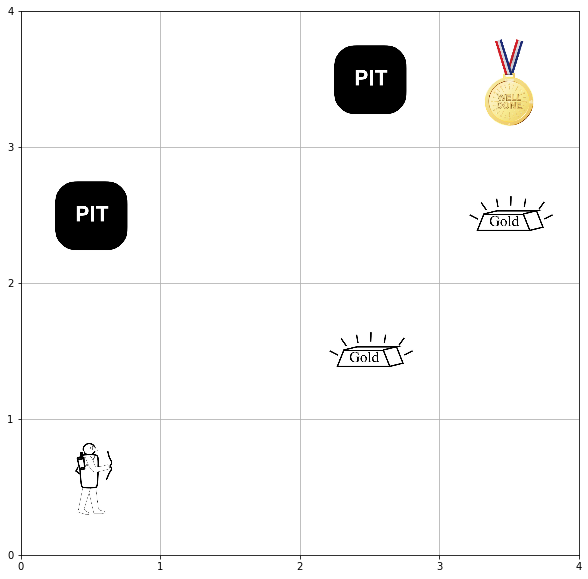


--------------- After Timestep 2 ---------------
current state: [0, 1]
chosen action: Right
reward after current step: 0.0
Total reward: 0.0


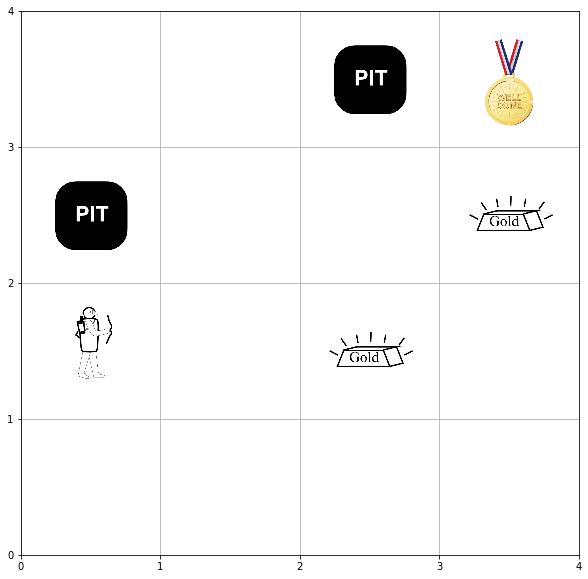


--------------- After Timestep 3 ---------------
current state: [1, 1]
chosen action: Down
reward after current step: 0.0
Total reward: 0.0


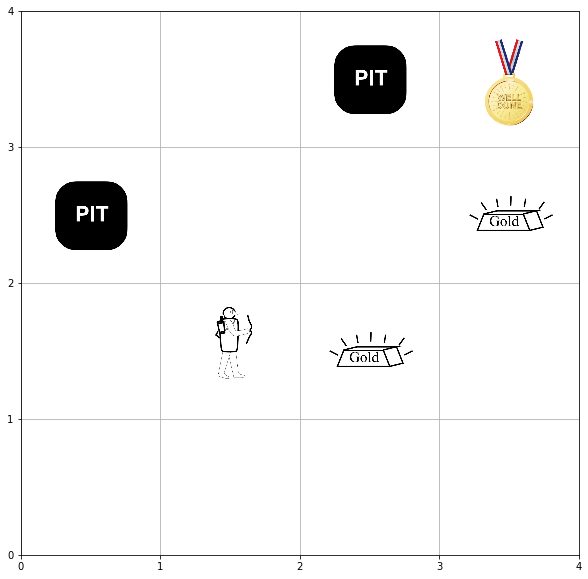


--------------- After Timestep 4 ---------------
current state: [1, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 0.0


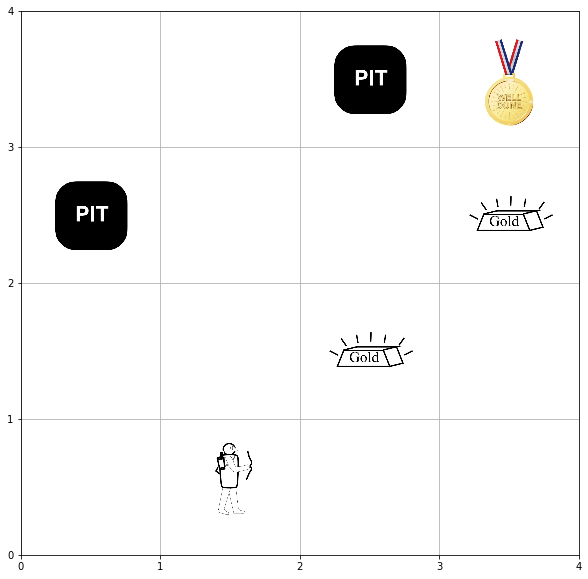


--------------- After Timestep 5 ---------------
current state: [2, 0]
chosen action: Down
reward after current step: 0.0
Total reward: 0.0


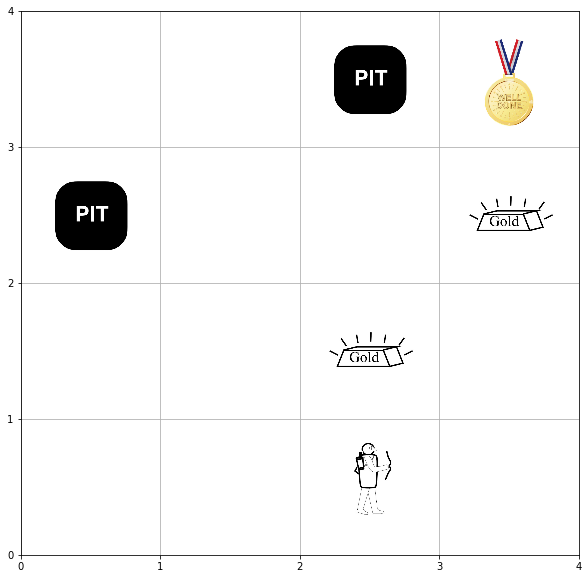


--------------- After Timestep 6 ---------------
current state: [2, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 0.0


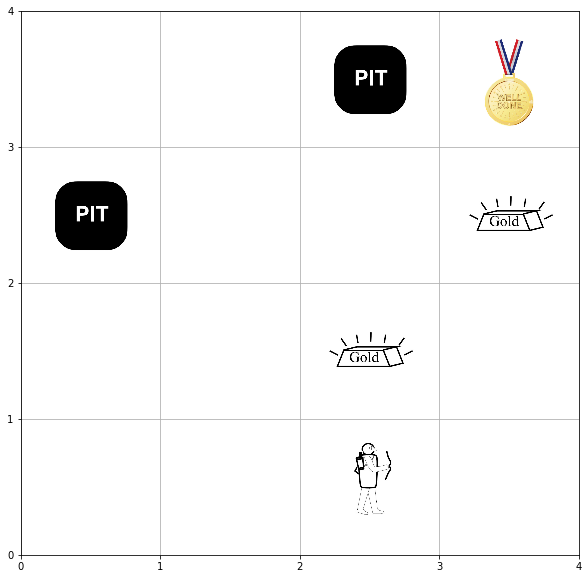


--------------- After Timestep 7 ---------------
current state: [3, 0]
chosen action: Down
reward after current step: 0.0
Total reward: 0.0


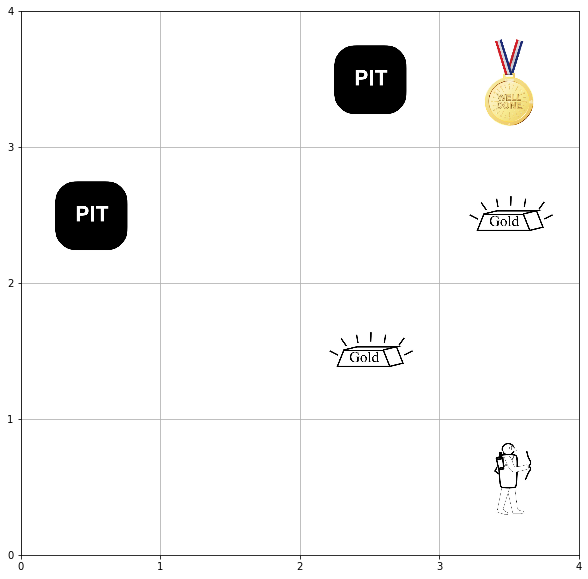


--------------- After Timestep 8 ---------------
current state: [3, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 0.0


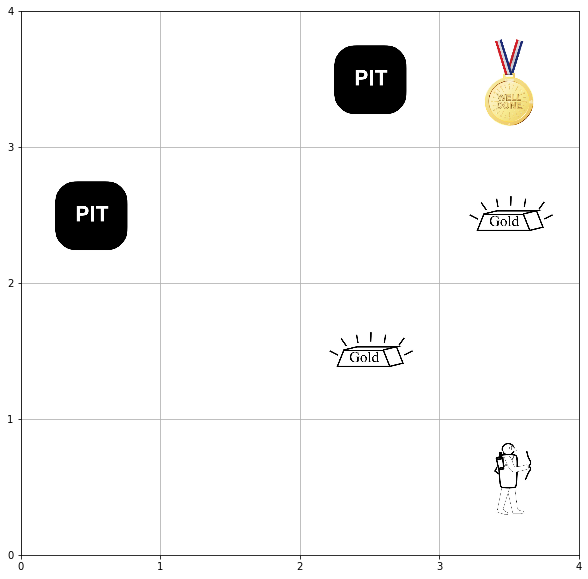


--------------- After Timestep 9 ---------------
current state: [3, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 0.0


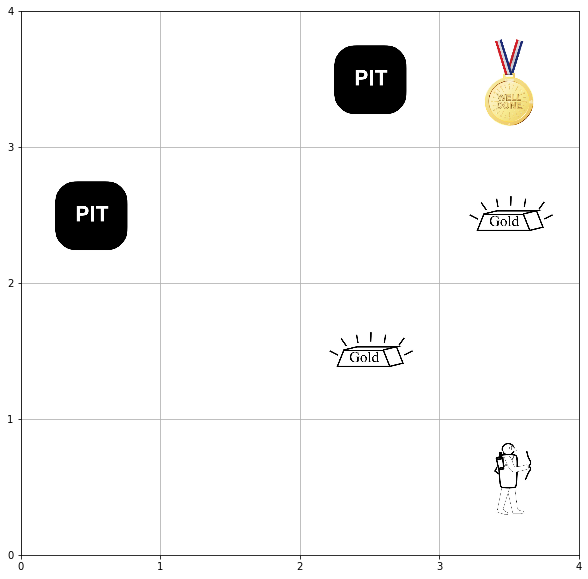


--------------- After Timestep 10 ---------------
current state: [3, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 0.0


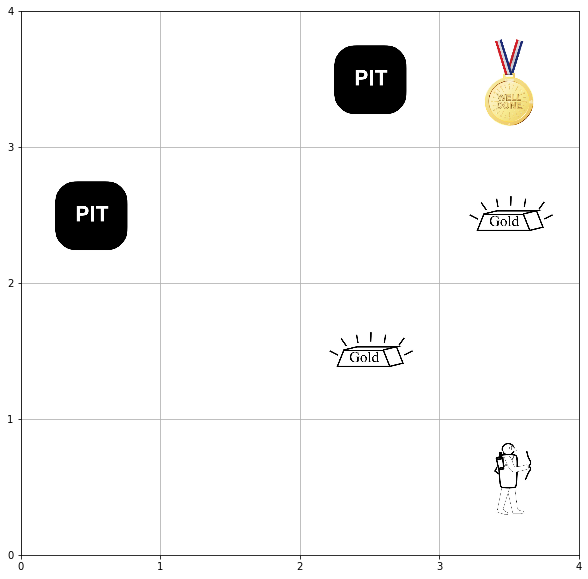


--------------- After Timestep 11 ---------------
current state: [2, 0]
chosen action: Up
reward after current step: 0.0
Total reward: 0.0


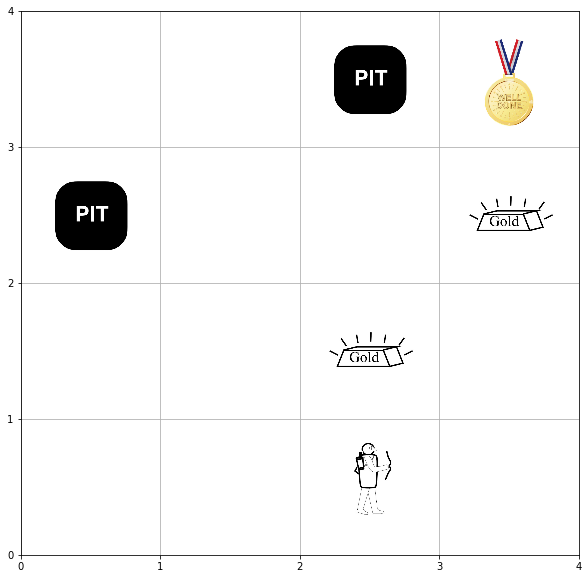


--------------- After Timestep 12 ---------------
current state: [3, 0]
chosen action: Down
reward after current step: 0.0
Total reward: 0.0


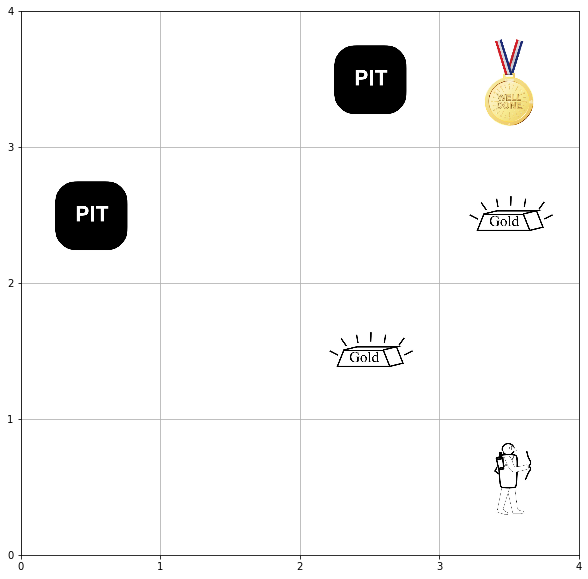


 ************* Episode 2 ends, Cumulative Rewards = 0.0 ************* 


 ************* Resetting the environment ************* 



In [30]:
env = LawnMowerDeterministicEnvironment(max_steps=12)
RandomAgent(env)

#Stochastic Environment

In [31]:
class LawnmoverStochasticEnvironment(gym.Env):
  metadata = {'render.modes' : []} 
  def __init__(self, n_rows = 4, n_columns = 4, A_pos = [0, 0], G_pos = [3, 3], max_steps = 15):
    # n_rows * n_columns states
    self.observation_space = spaces.Discrete(n_rows * n_columns)
    self.n_states = n_rows * n_columns
    self.n_rows = n_rows
    self.n_columns = n_columns
    
    # Possible actions [Up, Right, Down, Left]
    self.action_space = spaces.Discrete(4)
    self.n_actions = 4

    # Initialization of the State
    self.state = np.zeros((n_rows, n_columns))

    # Initial position of the agent
    self.agent_pos = [element for element in A_pos]
    self.start_pos = [element for element in A_pos]

    # Goal position
    self.goal_pos = [element for element in G_pos]

    # Positive Rewards Placement
    self.positive_Reward_Pos = [[3, 2], [2, 1], [3, 3]]
    self.state[tuple(self.positive_Reward_Pos[0])] = 10
    self.state[tuple(self.positive_Reward_Pos[1])] = 14
    self.state[tuple(self.goal_pos)] = 20

    # Negative Rewards Placement
    self.negative_Reward_Pos = [[0, 2], [2, 3]]
    self.state[tuple(self.negative_Reward_Pos[0])] = -15
    self.state[tuple(self.negative_Reward_Pos[1])] = -13
    self.state[tuple(self.agent_pos)] = 1
    self.done = False
    self.total_reward = 0
    self.timestep = 0
    self.max_Timestep = max_steps
    
    
    
  def reset(self):
    # Initialization of the state
    self.state = np.zeros((self.n_rows, self.n_columns))

    # Initial position of the agent
    self.agent_pos = [element for element in self.start_pos]

    # Positive Rewards Placement
    self.state[tuple(self.positive_Reward_Pos[0])] = 10
    self.state[tuple(self.positive_Reward_Pos[1])] = 14
    self.state[tuple(self.goal_pos)] = 20

    # Negative Rewards Placement
    self.state[tuple(self.negative_Reward_Pos[0])] = -15
    self.state[tuple(self.negative_Reward_Pos[1])] = -13
    self.state[tuple(self.agent_pos)] = 1
    self.done = False
    self.total_reward = 0
    self.timestep = 0
    
  def clip(self):
    '''clips the position if it goes out of bounds'''
    if self.agent_pos[0] < 0:
      self.agent_pos[0] = 0
    elif self.agent_pos[0] >= self.n_rows:
      self.agent_pos[0] = self.n_rows - 1
    if self.agent_pos[1] < 0:
      self.agent_pos[1] = 0
    elif self.agent_pos[1] >= self.n_columns:
      self.agent_pos[1] = self.n_columns - 1
    pass

  def step(self, action):
    '''
      Input - Action: 0[Up], 1[Right], 2[Down], 3[Left]
      Returns -
        agent_pos - Agent current position after applying the move
        reward - Reward gained by current action
        done - Goal reached status (True/False)
        info - Additional info if any
    '''
    self.state[tuple(self.agent_pos)] = 0
    probability = random.random()
    #The probability of occuring a random action instead of the specified one by the agent is 0.2
    if probability < 0.2:
      prev_action = action
      action = self.action_space.sample()
      while prev_action == action:
        action = self.action_space.sample()
      map_action = {0: 'Up', 1: 'Right', 2: 'Down', 3: 'Left'}
      #print("updated action in stochastic environment:",  map_action[action])
      
    if action == 0: #Up
      self.agent_pos[0] -= 1
    elif action == 1: #Right
      self.agent_pos[1] += 1
    elif action == 2: #Down
      self.agent_pos[0] += 1
    elif action == 3: #Left
      self.agent_pos[1] -= 1
    
    self.clip()

    cur_reward = self.state[tuple(self.agent_pos)]
    
    self.total_reward += cur_reward
    self.state[tuple(self.agent_pos)] = 1
    self.timestep += 1

    self.done = True if (self.agent_pos == self.goal_pos or self.timestep >= self.max_Timestep) else False
    info = {}
    observation = self.state.flatten()
    return observation, cur_reward, self.done, info
    

  def render(self):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 4)
    def plot_image(plot_pos):
      #print(plot_pos)
      plot_agent, plot_gold, plot_pit, plot_dest = False, False, False, False
      if np.array_equal(self.agent_pos, plot_pos):
        plot_agent = True
      elif np.array_equal(plot_pos, self.goal_pos):
        plot_dest = True
      elif self.state[tuple(plot_pos)] > 0:  # Gold isn't plotted if it has already been picked by one of the agents.
        plot_gold = True
      elif self.state[tuple(plot_pos)] < 0:
        plot_pit = True
      #if any(np.array_equal(self.negative_Reward_Pos[i], plot_pos) for i in range(len(self.negative_Reward_Pos))):
       # plot_pit = True
      #if any(np.array_equal(self.postive_Reward_Pos[i], plot_pos) for i in range(len(self.postive_Reward_Pos))):
       # plot_gold = True
      if plot_agent and all(not item for item in
                        [plot_gold, plot_pit, plot_dest]):
        agent = AnnotationBbox(OffsetImage(plt.imread('wumpus.png'), zoom=0.15),
                                       np.add(plot_pos, [0.5, 0.5]), frameon=False)
        ax.add_artist(agent)
      elif plot_gold and \
                    all(not item for item in
                        [plot_agent, plot_pit, plot_dest]):
                gold = AnnotationBbox(OffsetImage(plt.imread('gold.png'), zoom=0.15),
                                      np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(gold)
      elif plot_pit and \
                    all(not item for item in
                        [plot_gold, plot_agent, plot_dest]):
                pit = AnnotationBbox(OffsetImage(plt.imread('pit.png'), zoom=0.15),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(pit)
      elif plot_dest and \
                    all(not item for item in
                        [plot_gold, plot_pit, plot_agent]):
                pit = AnnotationBbox(OffsetImage(plt.imread('destination.png'), zoom=0.3),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(pit)
      else:
        pit = AnnotationBbox(OffsetImage(plt.imread('empty.png'), zoom=0.25),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
        ax.add_artist(pit)
    coordinates_state_mapping_2 = {}
    for j in range(4 * 4):
        coordinates_state_mapping_2[j] = np.asarray(
            [j % 4, int(np.floor(j / 4))])

    # Images Rendering for all the states.
    for position in coordinates_state_mapping_2:
      plot_image(coordinates_state_mapping_2[position])

    plt.xticks([0, 1, 2, 3, 4])
    plt.yticks([0, 1, 2, 3, 4])
    plt.grid()
    plt.show()


In [32]:
def Stochastic_RandomAgent(env):
  map_action = {0: 'Up', 1: 'Right', 2: 'Down', 3: 'Left'}
  for i in range(2):
    print(f"************* Episode {i+1} *************")
    env.reset()
    print("--------------- initial state ---------------")
    print("current state:", env.agent_pos)
    env.render()

    for step in range(0,env.max_Timestep):
      action = env.action_space.sample()
      observation, reward, done, _ = env.step(action)
      print(f"\n--------------- After Timestep {step+1} ---------------")
      print("current state:", env.agent_pos)
      print("chosen action:",  map_action[action])
      print("reward after current step:",  reward)
      print("Total reward:", env.total_reward)
      env.render()
      if done:
        #env.render()
        print(f"\n ************* Episode {i+1} ends, Cumulative Rewards = {env.total_reward} ************* \n")
        print("\n ************* Resetting the environment ************* \n")
        break



************* Episode 1 *************
--------------- initial state ---------------
current state: [0, 0]


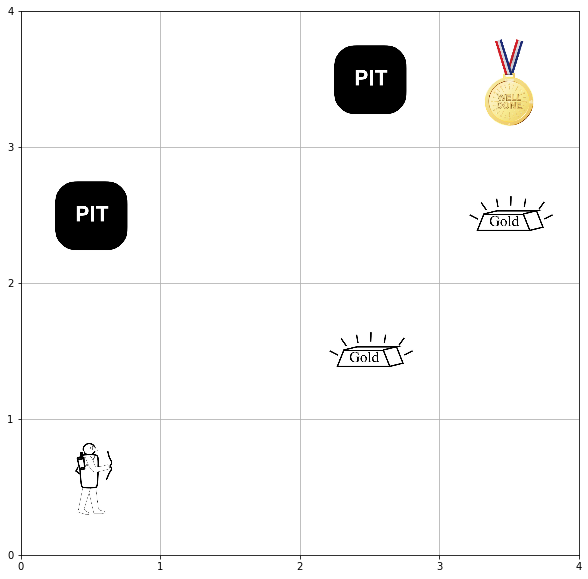


--------------- After Timestep 1 ---------------
current state: [0, 1]
chosen action: Right
reward after current step: 0.0
Total reward: 0.0


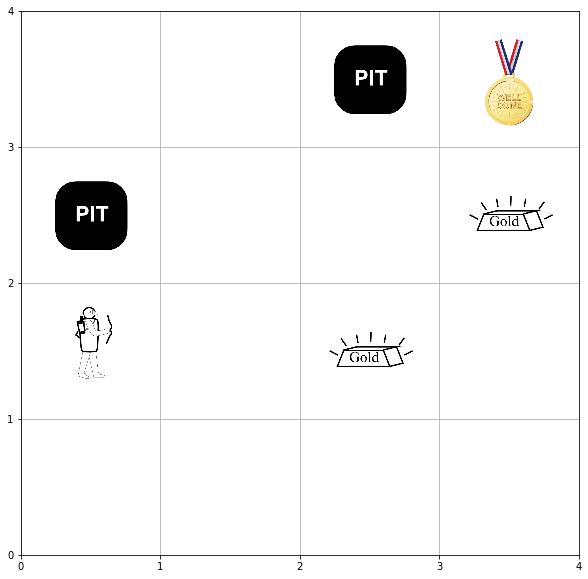


--------------- After Timestep 2 ---------------
current state: [1, 1]
chosen action: Down
reward after current step: 0.0
Total reward: 0.0


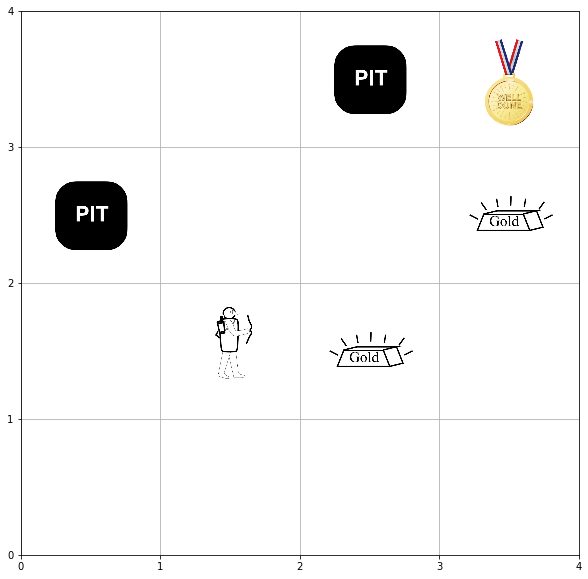


--------------- After Timestep 3 ---------------
current state: [0, 1]
chosen action: Up
reward after current step: 0.0
Total reward: 0.0


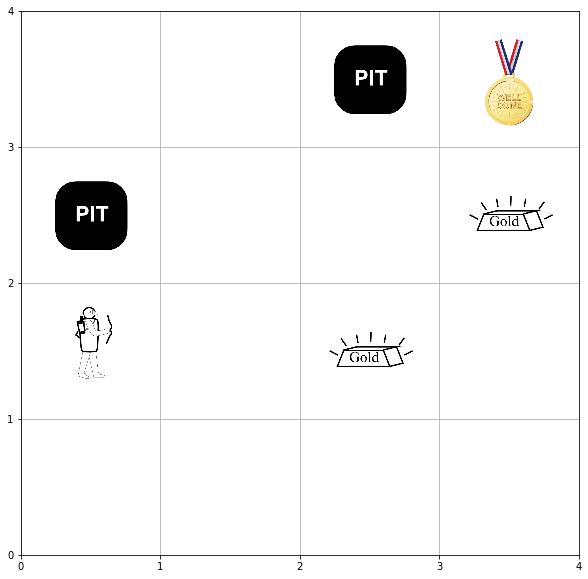


--------------- After Timestep 4 ---------------
current state: [0, 1]
chosen action: Up
reward after current step: 0.0
Total reward: 0.0


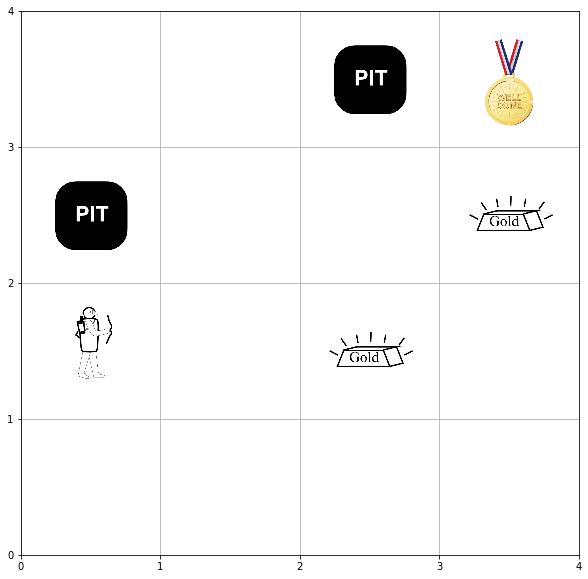


--------------- After Timestep 5 ---------------
current state: [0, 2]
chosen action: Right
reward after current step: -15.0
Total reward: -15.0


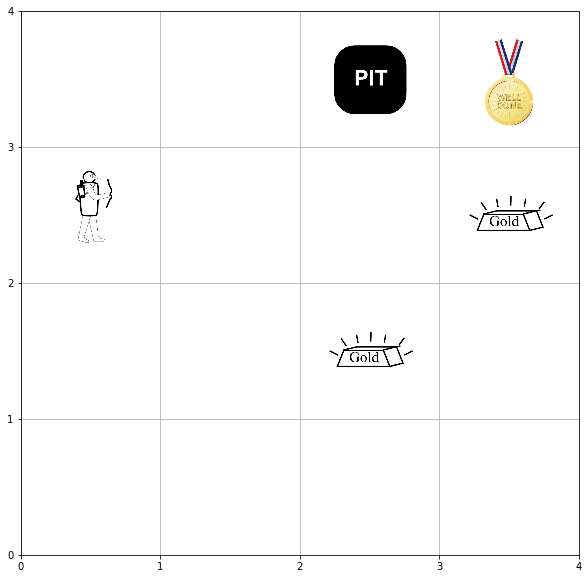


--------------- After Timestep 6 ---------------
current state: [0, 1]
chosen action: Up
reward after current step: 0.0
Total reward: -15.0


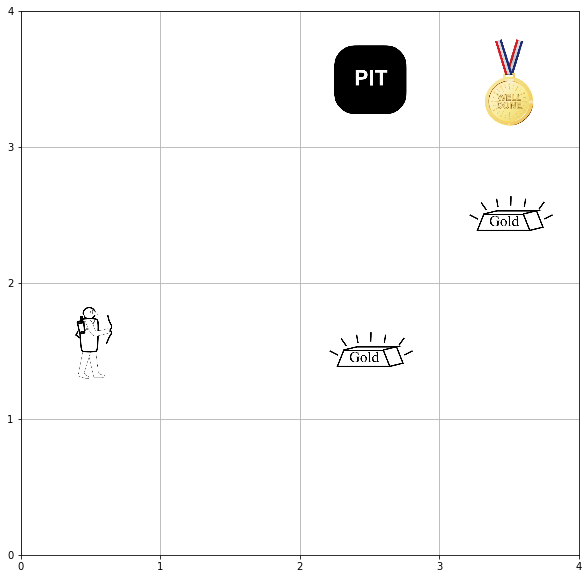


--------------- After Timestep 7 ---------------
current state: [0, 2]
chosen action: Right
reward after current step: 0.0
Total reward: -15.0


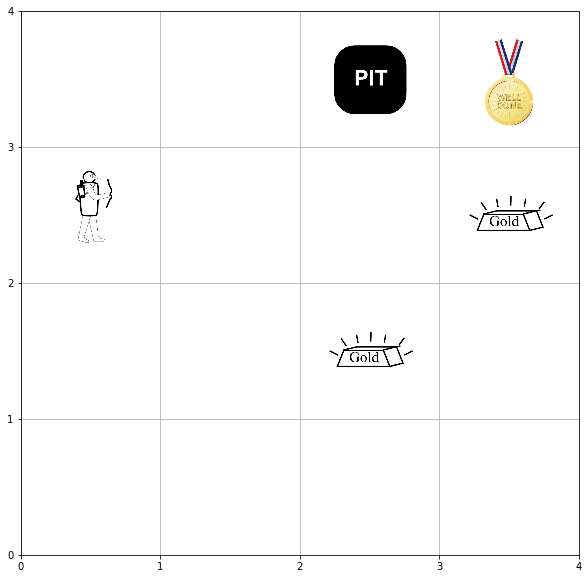


--------------- After Timestep 8 ---------------
current state: [0, 1]
chosen action: Left
reward after current step: 0.0
Total reward: -15.0


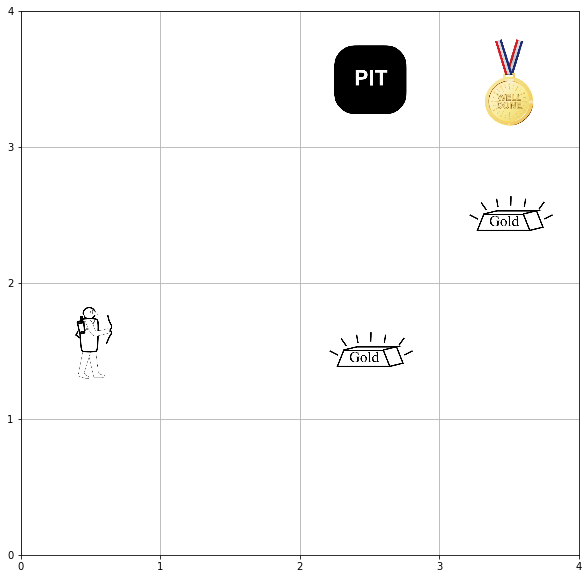


--------------- After Timestep 9 ---------------
current state: [0, 2]
chosen action: Up
reward after current step: 0.0
Total reward: -15.0


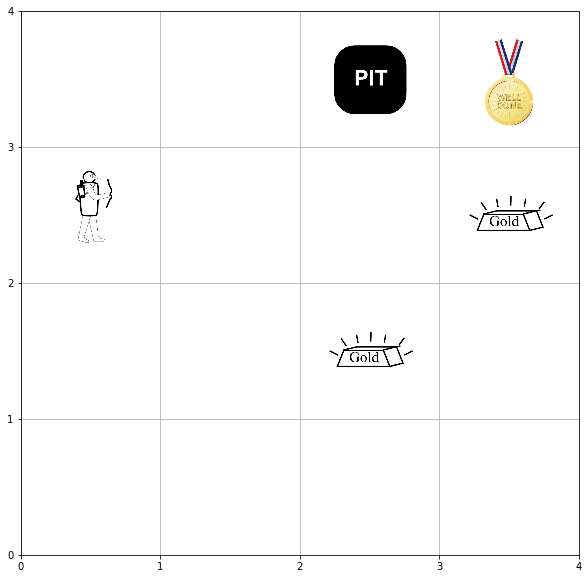


--------------- After Timestep 10 ---------------
current state: [0, 2]
chosen action: Up
reward after current step: 0.0
Total reward: -15.0


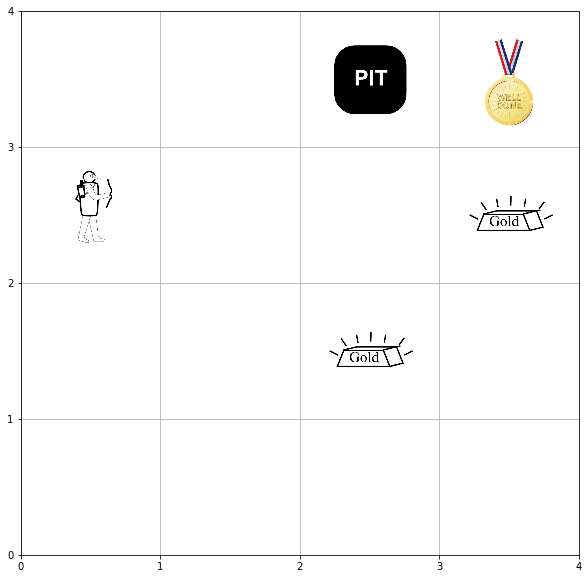


--------------- After Timestep 11 ---------------
current state: [0, 3]
chosen action: Right
reward after current step: 0.0
Total reward: -15.0


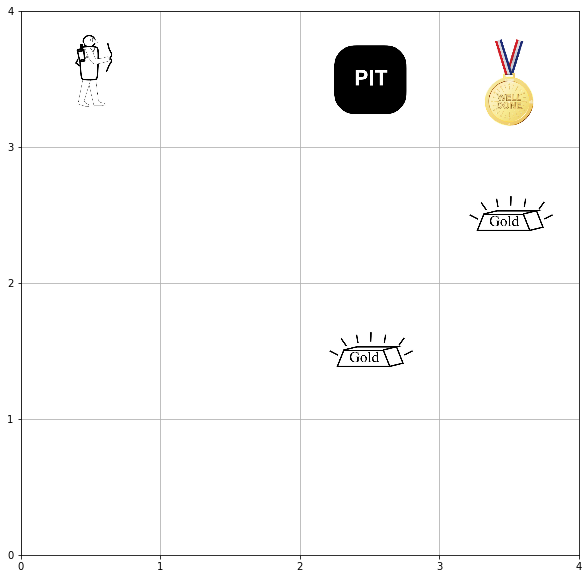


--------------- After Timestep 12 ---------------
current state: [1, 3]
chosen action: Down
reward after current step: 0.0
Total reward: -15.0


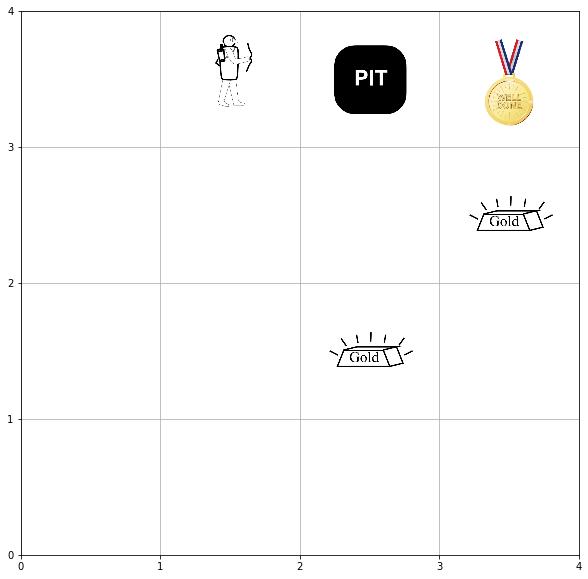


 ************* Episode 1 ends, Cumulative Rewards = -15.0 ************* 


 ************* Resetting the environment ************* 

************* Episode 2 *************
--------------- initial state ---------------
current state: [0, 0]


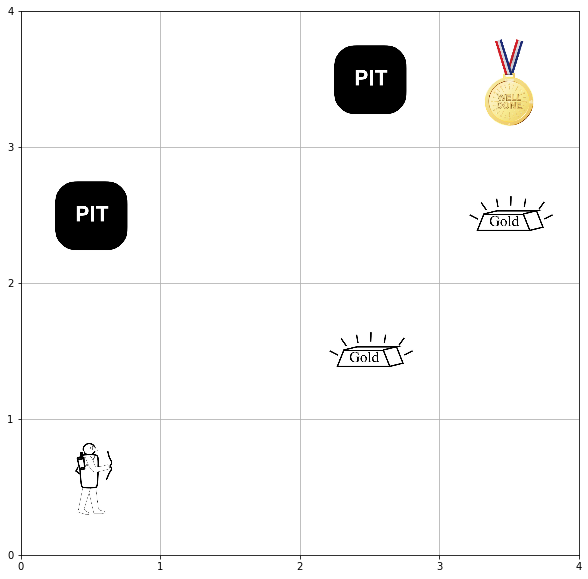


--------------- After Timestep 1 ---------------
current state: [1, 0]
chosen action: Down
reward after current step: 0.0
Total reward: 0.0


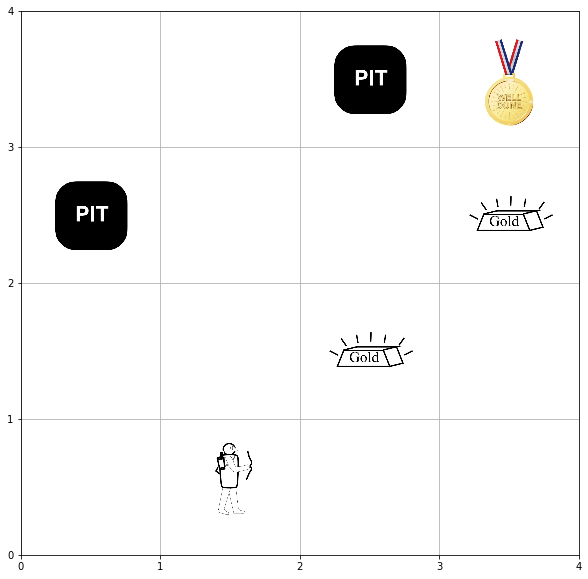


--------------- After Timestep 2 ---------------
current state: [1, 0]
chosen action: Left
reward after current step: 0.0
Total reward: 0.0


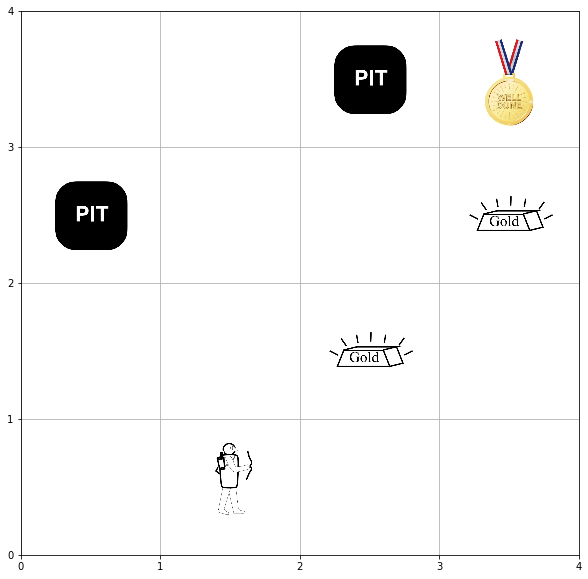


--------------- After Timestep 3 ---------------
current state: [2, 0]
chosen action: Up
reward after current step: 0.0
Total reward: 0.0


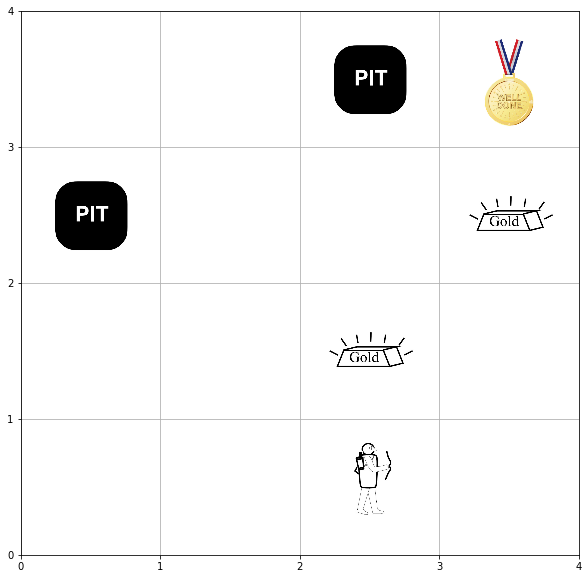


--------------- After Timestep 4 ---------------
current state: [3, 0]
chosen action: Up
reward after current step: 0.0
Total reward: 0.0


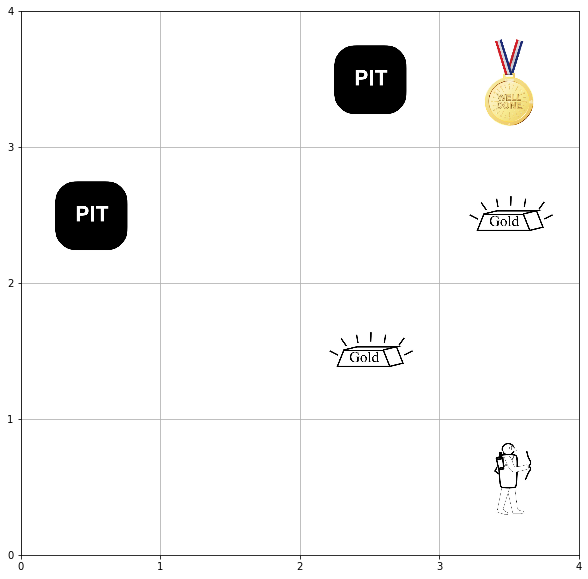


--------------- After Timestep 5 ---------------
current state: [3, 0]
chosen action: Up
reward after current step: 0.0
Total reward: 0.0


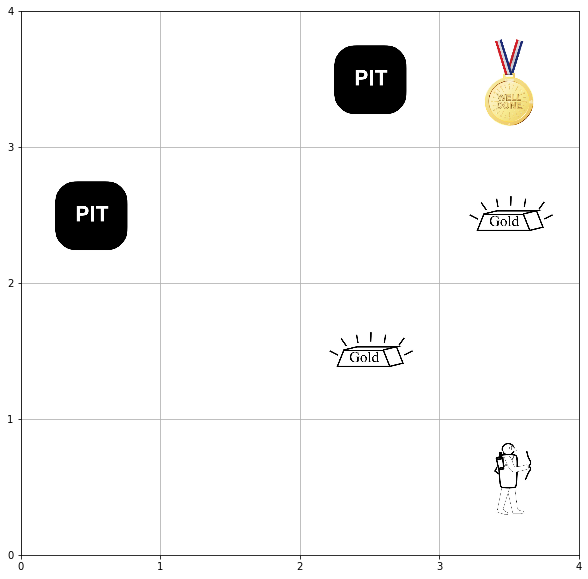


--------------- After Timestep 6 ---------------
current state: [3, 1]
chosen action: Right
reward after current step: 0.0
Total reward: 0.0


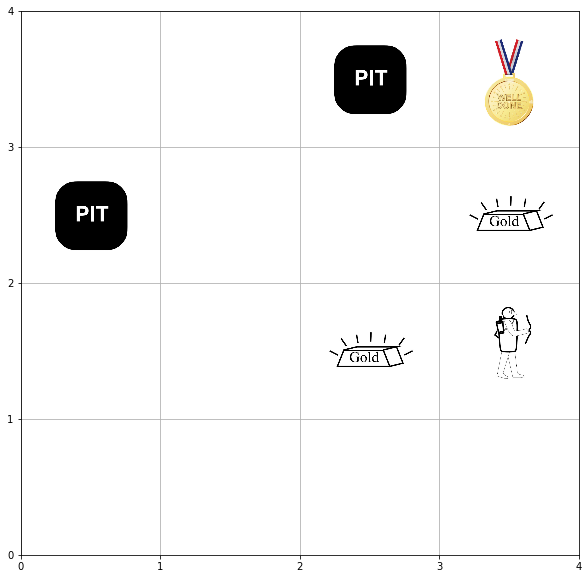


--------------- After Timestep 7 ---------------
current state: [2, 1]
chosen action: Up
reward after current step: 14.0
Total reward: 14.0


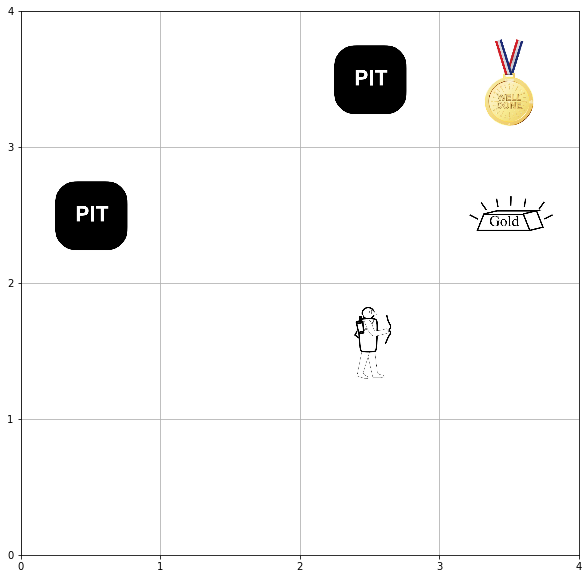


--------------- After Timestep 8 ---------------
current state: [1, 1]
chosen action: Up
reward after current step: 0.0
Total reward: 14.0


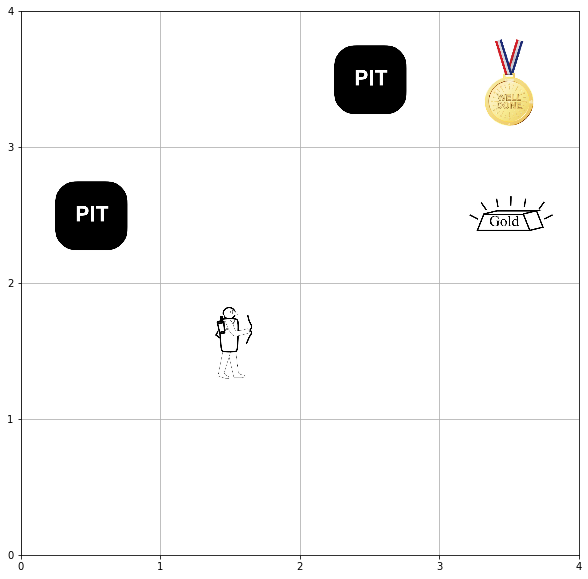


--------------- After Timestep 9 ---------------
current state: [0, 1]
chosen action: Up
reward after current step: 0.0
Total reward: 14.0


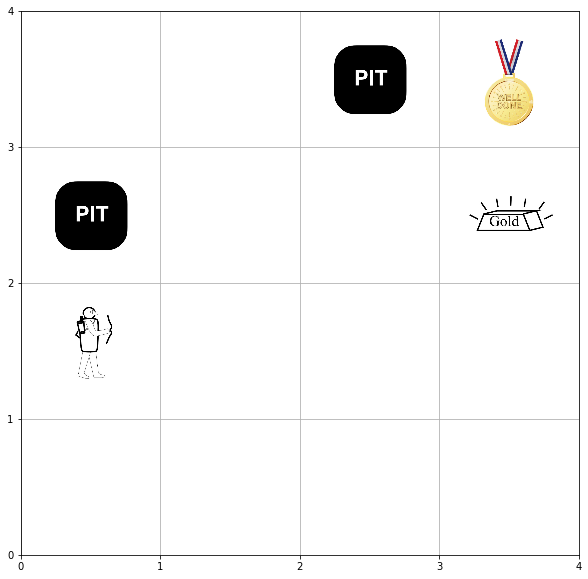


--------------- After Timestep 10 ---------------
current state: [0, 2]
chosen action: Right
reward after current step: -15.0
Total reward: -1.0


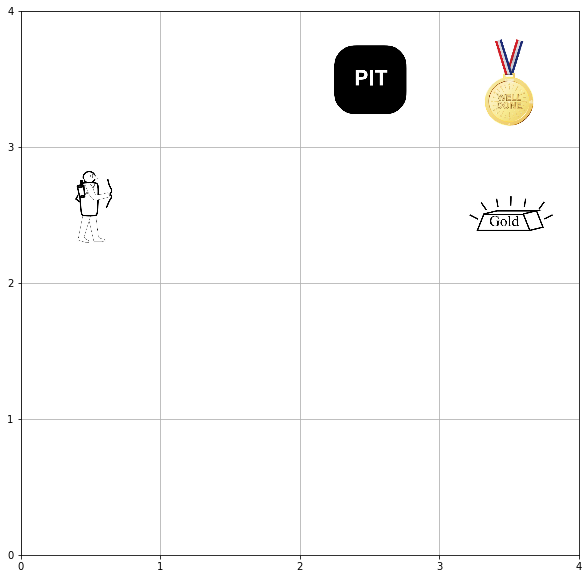


--------------- After Timestep 11 ---------------
current state: [0, 3]
chosen action: Down
reward after current step: 0.0
Total reward: -1.0


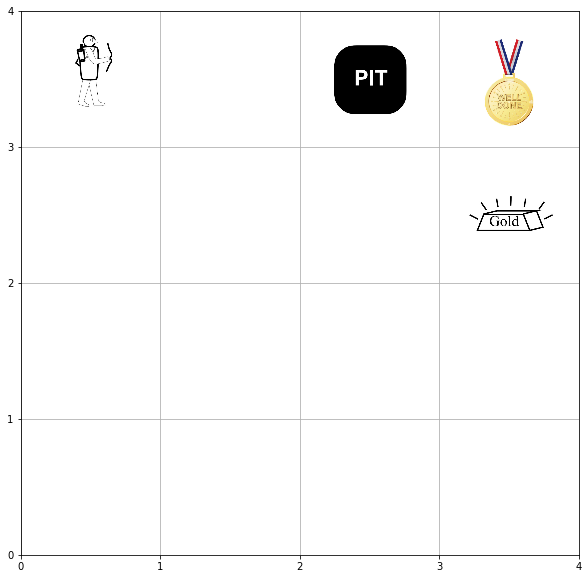


--------------- After Timestep 12 ---------------
current state: [0, 3]
chosen action: Right
reward after current step: 0.0
Total reward: -1.0


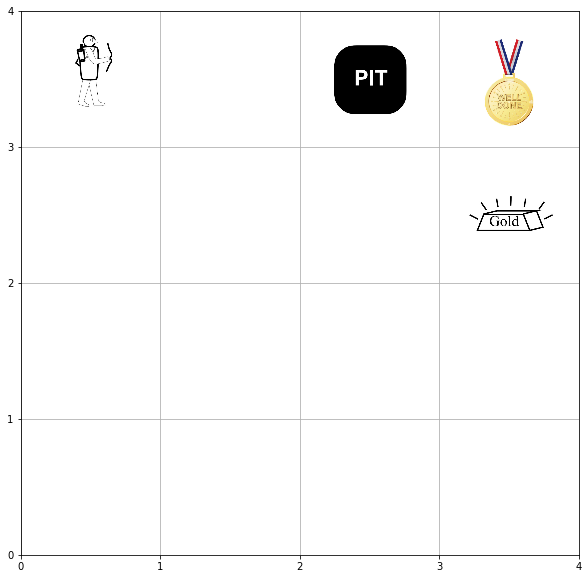


 ************* Episode 2 ends, Cumulative Rewards = -1.0 ************* 


 ************* Resetting the environment ************* 



In [33]:
s_env = LawnmoverStochasticEnvironment(max_steps=12)
Stochastic_RandomAgent(s_env)

#PART - 2

###Deterministic Environment

####Q-Learning Algorithm

In [34]:
class Q_Learning():
  def __init__(self, environment,learning_rate = 0.01, n_episodes = 1500, epsilon = 1.0, discount_factor = 0.3, epsilon_decay = 0.01):
    self.alpha = learning_rate
    self.n_episodes = n_episodes
    self.epsilon = epsilon
    self.gamma = discount_factor
    self.epsilon_decay = epsilon_decay
    self.env = environment
    
    self.Q_Table = np.random.random((self.env.n_states, self.env.n_actions))
    self.Q_Table[self.env.n_states - 1,:] = 0
    
    self.state_map = []
    states_count = 0
    for i in range(self.env.n_rows):
      self.state_map.append([])
      for j in range(self.env.n_columns):
        self.state_map[i].append(states_count)
        states_count += 1
    self.games_reward = []
    self.decay_growth = []
    self.evaluation_results = []
    pass
  def plot_graph(self, data=None, x_label="", y_label="", title=""):
    if data is None:
      print("There isn't any data to plot")
      return 
    print("\n")
    plt.plot(data)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    pass
  def greedy(self, cur_state):
    return np.argmax(self.Q_Table[cur_state])
  
  def epsilon_greedy(self, cur_state):
    '''Epsilon greedy policy'''

    if np.random.uniform(0,1) < self.epsilon:
        return self.env.action_space.sample()
    else:
        return self.greedy(cur_state)
  
  def train_Model(self):
    for episode in range(self.n_episodes):
      self.env.reset()
      state = self.state_map[self.env.agent_pos[0]][self.env.agent_pos[1]]
      done = False
      tot_rew = 0
      
      self.epsilon = max(0.01, self.epsilon - (self.epsilon * self.epsilon_decay))
      action = self.epsilon_greedy(state) 
      
      while not done:
        observation, rew, done, _ = self.env.step(action)
        next_state = self.state_map[self.env.agent_pos[0]][self.env.agent_pos[1]]
        next_action = self.epsilon_greedy(next_state)

        gamma_multiplier = self.Q_Table[next_state][self.greedy(next_action)]
        self.Q_Table[state][action] = self.Q_Table[state][action] + self.alpha * (rew +
                                                                                     self.gamma * gamma_multiplier -
                                                                                     self.Q_Table[state][action])
        state = next_state
        action = next_action
        tot_rew += rew

        if done:
          self.games_reward.append(tot_rew)
          self.decay_growth.append(self.epsilon)
  
  def evaluate_model(self, test_n_episodes = 10):
    output_grid = widgets.Grid(1,1)
    for ep in range(test_n_episodes):
      env.reset()
      state = self.state_map[env.agent_pos[0]][env.agent_pos[1]]
      done = False
      tot_rew = 0
      with output_grid.output_to(0,0):
        env.render()
        time.sleep(0.2)
        output_grid.clear_cell()
      while not done:
        action = self.greedy(state)
        observation, rew, done, _ = env.step(action) 
        state = self.state_map[env.agent_pos[0]][env.agent_pos[1]]

        tot_rew += rew
        with output_grid.output_to(0,0):
          env.render()
          time.sleep(0.2)
          output_grid.clear_cell()
        if done:
          self.evaluation_results.append(tot_rew)
    pass
    


In [35]:
Deterministic_QL_env = LawnMowerDeterministicEnvironment(max_steps=30)
basic_QL_D_ENV = Q_Learning(Deterministic_QL_env, learning_rate=0.1, n_episodes=1500, epsilon=1, discount_factor=0.4, epsilon_decay=0.01)
print("\nInitial Q Table with random Values")
print(basic_QL_D_ENV.Q_Table)


Initial Q Table with random Values
[[0.28148921 0.51410008 0.3804127  0.45678192]
 [0.55592065 0.96342526 0.80040488 0.23638724]
 [0.98671283 0.90064892 0.79373547 0.19502636]
 [0.09462682 0.03829508 0.65220415 0.58258751]
 [0.24116741 0.56883763 0.28049391 0.10742285]
 [0.15619548 0.91978045 0.87715469 0.48675399]
 [0.83268178 0.77172382 0.30498943 0.83591524]
 [0.3230958  0.71394409 0.74240199 0.693983  ]
 [0.43849103 0.40768559 0.28705148 0.72943565]
 [0.52428867 0.45750327 0.63701605 0.34520347]
 [0.5008174  0.71666431 0.37122281 0.58025826]
 [0.5509682  0.54518823 0.76464883 0.699625  ]
 [0.12186498 0.81354749 0.04937784 0.50580205]
 [0.44593612 0.39140938 0.03304634 0.31751254]
 [0.90035582 0.98897483 0.46942052 0.52006163]
 [0.         0.         0.         0.        ]]


In [36]:
'''Preparing the Q tables using Q learning algorithm'''

basic_QL_D_ENV.train_Model()


In [37]:
'''Printing final Q tables obtained after running Q-learning algorithm'''
print("\nFinal Q Table Values for deterministic environment")
print(basic_QL_D_ENV.Q_Table)

with open('Deterministic_q_table_q_learning_values.pickle', 'wb') as handle:
    pickle.dump(basic_QL_D_ENV.Q_Table, handle, protocol=pickle.HIGHEST_PROTOCOL)


Final Q Table Values for deterministic environment
[[ 1.58005923e-02  2.24122823e+00  3.65421205e-02  8.70161003e-03]
 [ 1.30130856e+00 -1.38150082e+01  5.60573339e+00  3.16318449e-02]
 [ 2.31529920e-01  2.39127552e-01  1.18795173e+00  9.91355811e-02]
 [ 1.46073176e-01  8.23332153e-02  2.09575103e-01  2.37780569e-01]
 [ 1.42144934e-02  5.04447708e+00  8.94484836e-02  5.02963925e-02]
 [ 1.05175319e+00  1.39517265e+00  1.40153330e+01  1.05232968e-01]
 [-8.91078517e+00  1.04976337e-01  1.76955227e+00  5.14773200e+00]
 [ 2.64352646e-01  3.12180331e-01 -2.55899217e-01  6.25977875e-01]
 [ 1.53134331e-01  1.65678488e+00  9.56016557e-02  3.06729786e-01]
 [ 3.44320084e+00  4.11433342e+00  3.83384918e-02  5.01384163e-02]
 [ 1.26288036e+00 -6.09402992e+00  1.02894805e+01  4.97882907e-01]
 [ 1.54181213e-01  2.98350018e+00  1.90939902e+01  5.96080198e-01]
 [ 7.80288192e-02  2.49230620e-01  3.61922213e-02  2.04308021e-01]
 [ 1.81350857e+00  2.59403491e+00  7.77458328e-02  1.11183226e-01]
 [ 3.90582

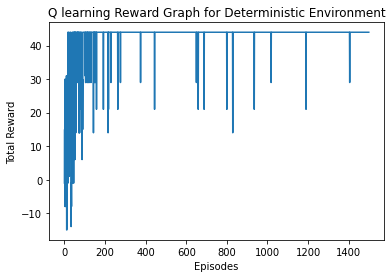

In [38]:
'''plotting graph for total_reward'''
basic_QL_D_ENV.plot_graph(basic_QL_D_ENV.games_reward, x_label="Episodes",
                           y_label = "Total Reward", title = "Q learning Reward Graph for Deterministic Environment")


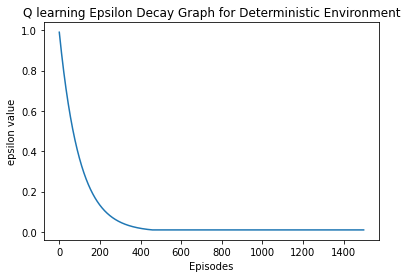

In [39]:

'''plotting graph for epsilon decay'''
basic_QL_D_ENV.plot_graph(basic_QL_D_ENV.decay_growth, x_label="Episodes",
                           y_label = "epsilon value", title = "Q learning Epsilon Decay Graph for Deterministic Environment")


In [40]:
basic_QL_D_ENV.evaluate_model(15)


""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

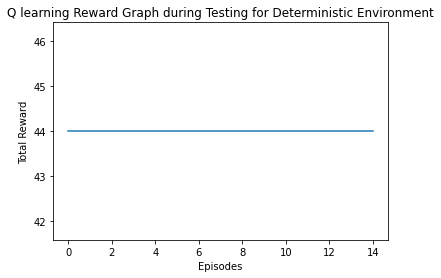

In [41]:
'''plotting graph for test games reward'''
basic_QL_D_ENV.plot_graph(basic_QL_D_ENV.evaluation_results, x_label="Episodes", 
                           y_label = "Total Reward", title="Q learning Reward Graph during Testing for Deterministic Environment")


####SARSA Algorithm

In [42]:
class SARSA_():
  def __init__(self, Environment, Learning_Rate = 0.01, n_episodes = 500, Epsilon = 1.0, Discount_Factor = 0.3, Epsilon_Decay = 0.01):
    self.alpha = Learning_Rate
    self.n_episodes = n_episodes
    self.epsilon = Epsilon
    self.gamma = Discount_Factor
    self.epsilon_decay = Epsilon_Decay
    self.env = Environment
    self.Q_Table = np.random.random((self.env.n_states, self.env.n_actions))
    self.Q_Table[self.env.n_states - 1,:] = 0
    self.state_map = []
    states_count = 0
    for i in range(self.env.n_rows):
      self.state_map.append([])
      for j in range(self.env.n_columns):
        self.state_map[i].append(states_count)
        states_count += 1
    self.games_reward = []
    self.decay_growth = []
    self.evaluation_results = []
    pass
  def plot_graph(self, data=None, x_label="", y_label="", title=""):
    '''Plotting graph with given data'''
    if data is None:
      print("There isn't any data to plot")
      return 
    print("\n")
    plt.plot(data)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    pass
  def greedy(self, cur_state):
    ''' Greedy Policy'''
    return np.argmax(self.Q_Table[cur_state])
  
  def epsilon_greedy(self, cur_state):
    '''Epsilon greedy policy'''
    if np.random.uniform(0,1) < self.epsilon:
        return self.env.action_space.sample()
    else:
        return self.greedy(cur_state)
  
  def train_Model(self):
    for episode in range(self.n_episodes):
      self.env.reset()
      state = self.state_map[self.env.agent_pos[0]][self.env.agent_pos[1]]
      done = False
      self.epsilon = max(0.01, self.epsilon - (self.epsilon * self.epsilon_decay))
      
      action = self.epsilon_greedy(state) 
      # Running actions until environment reaches final goal or exceeds max timesteps
      while not done:
        observation, cur_reward, done, _ = self.env.step(action)
        next_state = self.state_map[self.env.agent_pos[0]][self.env.agent_pos[1]]
        next_action = self.epsilon_greedy(next_state)
        prev_q = tuple([state, action])
        cur_q = tuple([next_state, next_action])
        
        G = cur_reward + self.gamma * self.Q_Table[cur_q]
        self.Q_Table[prev_q] = self.Q_Table[prev_q] + self.alpha * (G - self.Q_Table[prev_q])

        state = next_state
        action = next_action
        if done:
          self.games_reward.append(self.env.total_reward)
          self.decay_growth.append(self.epsilon)
  def evaluate_model(self, test_n_episodes = 10):
    output_grid = widgets.Grid(1,1)
    for ep in range(test_n_episodes):
      self.env.reset()
      state = self.state_map[self.env.agent_pos[0]][self.env.agent_pos[1]]
      done = False
      tot_rew = 0
      with output_grid.output_to(0,0):
        self.env.render()
        time.sleep(0.2)
        output_grid.clear_cell()
      while not done:
        action = np.argmax(self.Q_Table[state])
        observation, rew, done, _ = self.env.step(action) 
        state = self.state_map[self.env.agent_pos[0]][self.env.agent_pos[1]]

        tot_rew += rew
        with output_grid.output_to(0,0):
          self.env.render()
          time.sleep(0.2)
          output_grid.clear_cell()
        if done:
          self.evaluation_results.append(tot_rew)
    pass


In [43]:
Deterministic_sarsa_env = LawnMowerDeterministicEnvironment(max_steps = 30)
basic_sarsa_D_ENV = SARSA_(Deterministic_sarsa_env, Learning_Rate=0.1, n_episodes=1000, Epsilon=1, Discount_Factor=0.4, Epsilon_Decay=0.01)
print("\nInitial Q Table with random Values")
print(basic_sarsa_D_ENV.Q_Table)


Initial Q Table with random Values
[[0.31890285 0.07476704 0.7908359  0.20029292]
 [0.67553768 0.71008913 0.30044448 0.65290182]
 [0.03606582 0.45724546 0.5957106  0.90847814]
 [0.65915067 0.41287628 0.01868703 0.35663029]
 [0.11751968 0.411855   0.23482392 0.68021925]
 [0.62433164 0.64011622 0.91130624 0.13450964]
 [0.91894482 0.285312   0.2671983  0.24119933]
 [0.5528629  0.29099326 0.85394093 0.15945239]
 [0.24807354 0.08799138 0.16799037 0.50002075]
 [0.95934481 0.58719023 0.76807396 0.10363989]
 [0.10707119 0.27044871 0.31799316 0.63047871]
 [0.74811286 0.11972678 0.74399155 0.68371808]
 [0.4679361  0.1434946  0.0962967  0.18500017]
 [0.64284061 0.37430878 0.43479696 0.37129823]
 [0.72639811 0.5830219  0.81927536 0.20851426]
 [0.         0.         0.         0.        ]]


In [44]:
'''Training the Q table using SARSA algorithm'''

basic_sarsa_D_ENV.train_Model()



In [45]:
'''Printing final Q table obtained after running sarsa algorithm'''
print(basic_sarsa_D_ENV.Q_Table)

with open('Deterministic_q_table_sarsa_values.pickle', 'wb') as handle:
    pickle.dump(basic_sarsa_D_ENV.Q_Table, handle, protocol=pickle.HIGHEST_PROTOCOL)


[[ 4.62406658e-01  1.41482040e+00  2.60722294e+00  5.16197504e-01]
 [-3.76306060e-01 -1.32524399e+01  5.96075755e+00  1.41543136e-01]
 [ 7.26433160e-02  1.14011853e-01  5.31006509e-01  1.07983640e-01]
 [ 5.90866740e-03 -1.02004984e-01 -5.83493958e-02 -2.02274319e+00]
 [ 4.49988631e-01  6.54899185e+00  2.31249058e+00  1.35949832e+00]
 [ 4.46284724e-01  6.47862529e-01  1.68686594e+01  1.47520874e+00]
 [-5.80359315e+00 -1.38397031e-01  7.88571300e-01  4.47249512e+00]
 [ 1.26983131e-01 -1.33466098e-01 -4.56380162e+00  2.52798848e-01]
 [ 2.43207671e-01  7.30940446e+00  3.96667503e-01  6.98968237e-01]
 [ 4.58960294e+00  3.52961585e+00  7.18922037e+00  2.69534665e+00]
 [ 1.07968484e-02 -6.36624062e+00  1.32834028e+01  3.03763640e+00]
 [ 5.15603865e-01  5.73346980e-01  1.51053810e+01  5.10558845e-01]
 [ 6.46848412e-01  5.08473879e+00  2.28508583e-01  6.06958567e-01]
 [ 1.87387075e+00  1.79947204e+01  5.18491768e+00  9.58206968e-01]
 [ 2.80840263e+00  2.00000000e+01  6.79688076e+00  4.98943627e

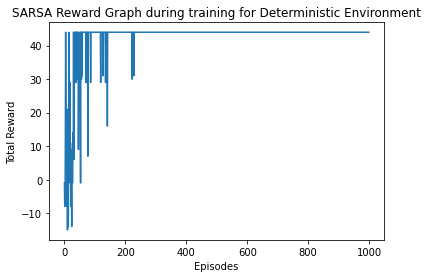

In [46]:
'''plotting graph for total_reward'''
basic_sarsa_D_ENV.plot_graph(basic_sarsa_D_ENV.games_reward, x_label="Episodes",
                           y_label = "Total Reward", title = "SARSA Reward Graph during training for Deterministic Environment")


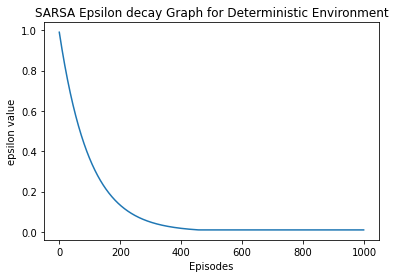

In [47]:
'''plotting graph for epsilon decay'''
basic_sarsa_D_ENV.plot_graph(basic_sarsa_D_ENV.decay_growth, x_label="Episodes",
                           y_label = "epsilon value", title = "SARSA Epsilon decay Graph for Deterministic Environment")


In [48]:
'''Evaluating the model'''
basic_sarsa_D_ENV.evaluate_model(15)

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

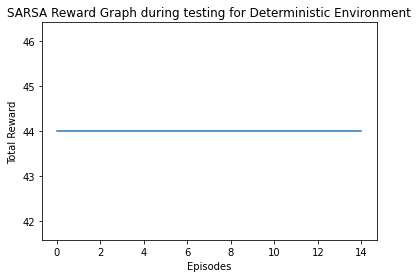

In [49]:
'''plotting graph for test games reward'''
basic_sarsa_D_ENV.plot_graph(basic_sarsa_D_ENV.evaluation_results, x_label="Episodes", 
                           y_label = "Total Reward", title="SARSA Reward Graph during testing for Deterministic Environment")


##Stochastic Environment

####Q-Learning Algorithm

In [50]:
Stochastic_QL_env = LawnmoverStochasticEnvironment(max_steps=30)
basic_QL_S_ENV = Q_Learning(Stochastic_QL_env, learning_rate=0.1, n_episodes=1500, epsilon=1, discount_factor=0.4, epsilon_decay=0.01)
print("\nInitial Q Table 1 with random Values")
print(basic_QL_S_ENV.Q_Table)


Initial Q Table 1 with random Values
[[0.66015739 0.86266071 0.322861   0.13307732]
 [0.27831194 0.85881138 0.09911216 0.85874933]
 [0.60346781 0.72698423 0.73473242 0.59853118]
 [0.45345782 0.91328305 0.71811863 0.15155239]
 [0.15805856 0.07196593 0.60759036 0.65694964]
 [0.76649474 0.53418026 0.07800404 0.10766656]
 [0.90085442 0.52881902 0.87149475 0.38703818]
 [0.02129061 0.38714027 0.78574843 0.05984135]
 [0.72295077 0.59100634 0.94142925 0.9055817 ]
 [0.95675434 0.53129226 0.80883129 0.28678077]
 [0.75983882 0.69613279 0.49301498 0.80160405]
 [0.19290652 0.02038774 0.48024543 0.92991902]
 [0.95690243 0.34937539 0.99094593 0.20470668]
 [0.72015137 0.94938185 0.69102479 0.70595644]
 [0.49650891 0.71637175 0.6660269  0.87900104]
 [0.         0.         0.         0.        ]]


In [51]:
'''Preparing the Q tables using Q learning algorithm'''

basic_QL_S_ENV.train_Model()


In [52]:
'''Printing final Q tables obtained after running Q-learning algorithm'''
print("\nFinal Q Table Values for Stochastic environment")
print(basic_QL_S_ENV.Q_Table)

with open('Stochastic_q_table_q_learning_values.pickle', 'wb') as handle:
    pickle.dump(basic_QL_S_ENV.Q_Table, handle, protocol=pickle.HIGHEST_PROTOCOL)


Final Q Table Values for Stochastic environment
[[-0.10622854 -2.10495728 -0.66961594 -0.61642264]
 [-3.3365728  -9.70309424 -0.74783082 -5.49839395]
 [-0.33347625 -0.77703064 -0.76609019 -0.90283273]
 [-1.5850473  -1.92651049 -0.55577776 -2.25680194]
 [-0.42938642 -0.24299769  0.04025427 -0.17984332]
 [-0.44066373 -0.76164417  8.83585265  1.05825017]
 [-5.03255068 -2.54290948 -2.05785006 -2.70733421]
 [-2.53924802 -2.05756748 -5.97779691 -1.74633652]
 [ 0.16417044 10.15668369  0.20065951  0.37232213]
 [-0.64953179 -1.00489488  0.45062079 -0.42793092]
 [ 0.06898311 -8.39456056  2.00543551 -1.14114909]
 [ 1.58871727  0.45033591 13.50981592  1.95329187]
 [ 0.11466376  0.3292947   0.12107503  0.11757689]
 [ 2.86376213  9.50013504  1.13749947  0.19225138]
 [-0.67297213 17.30552722  2.84067319  1.30608805]
 [ 0.          0.          0.          0.        ]]


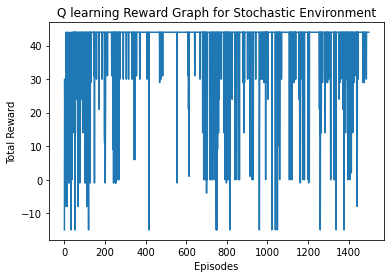

In [53]:
'''plotting graph for total_reward'''
basic_QL_S_ENV.plot_graph(basic_QL_S_ENV.games_reward, x_label="Episodes",
                           y_label = "Total Reward", title = "Q learning Reward Graph for Stochastic Environment")


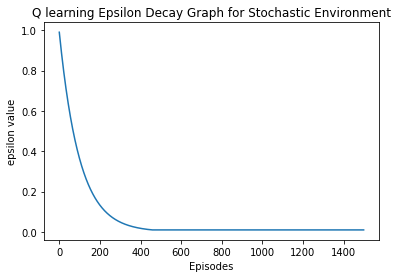

In [54]:

'''plotting graph for epsilon decay'''
basic_QL_S_ENV.plot_graph(basic_QL_S_ENV.decay_growth, x_label="Episodes",
                           y_label = "epsilon value", title = "Q learning Epsilon Decay Graph for Stochastic Environment")


In [55]:
basic_QL_S_ENV.evaluate_model(15)


""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

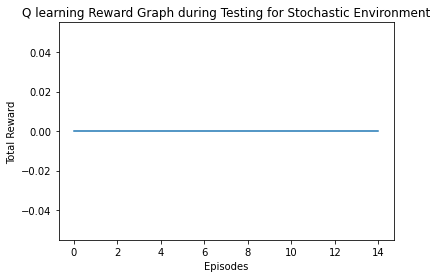

In [56]:
'''plotting graph for test games reward'''
basic_QL_S_ENV.plot_graph(basic_QL_S_ENV.evaluation_results, x_label="Episodes", 
                           y_label = "Total Reward", title="Q learning Reward Graph during Testing for Stochastic Environment")


####SARSA Algorithm

In [57]:
Stochastic_sarsa_env = LawnmoverStochasticEnvironment(max_steps = 30)
basic_sarsa_S_ENV = SARSA_(Stochastic_sarsa_env, Learning_Rate=0.1, n_episodes=1000, Epsilon=1, Discount_Factor=0.4, Epsilon_Decay=0.01)
print("\nInitial Q Table with random Values")
print(basic_sarsa_S_ENV.Q_Table)


Initial Q Table with random Values
[[2.61976119e-01 2.69089197e-01 8.07977780e-01 8.85987293e-01]
 [9.31805039e-01 8.42189182e-02 7.16896474e-01 7.28916524e-02]
 [1.89967978e-01 6.33056169e-02 5.68703466e-01 6.89316390e-01]
 [1.42327966e-02 1.16300323e-04 4.45670388e-01 8.48066498e-01]
 [6.74718425e-01 7.88766193e-01 2.55302037e-02 3.25535562e-01]
 [3.90011382e-01 9.13781026e-01 2.13896264e-01 3.72059293e-01]
 [9.16065981e-01 2.64357496e-01 5.92560870e-01 2.54374418e-01]
 [2.19397653e-01 8.24832252e-01 4.17190291e-01 2.09008457e-01]
 [3.72462735e-01 2.01250285e-01 3.89988611e-01 7.81137833e-01]
 [5.06220909e-01 6.86356434e-01 1.36901536e-01 2.88604807e-02]
 [1.26183683e-01 6.18311245e-01 3.70983938e-01 3.50693629e-02]
 [9.07441268e-01 9.60112331e-01 8.97614251e-02 1.05744374e-01]
 [1.84490719e-01 4.04664077e-01 8.31966853e-01 3.76496918e-01]
 [4.80238542e-01 9.91396940e-01 3.30856725e-01 8.54676048e-01]
 [2.71737083e-01 3.64394120e-01 1.66820463e-01 3.91390757e-01]
 [0.00000000e+00 0.

In [58]:
'''Training the Q table using SARSA algorithm'''

basic_sarsa_S_ENV.train_Model()



In [59]:
'''Printing final Q table obtained after running sarsa algorithm'''
print(basic_sarsa_S_ENV.Q_Table)

with open('Stochastic_q_table_sarsa_values.pickle', 'wb') as handle:
    pickle.dump(basic_sarsa_S_ENV.Q_Table, handle, protocol=pickle.HIGHEST_PROTOCOL)


[[ 2.87029392e-01  4.92951257e-02  1.61805408e+00  2.53337859e-01]
 [-1.83156285e+00 -7.59187051e+00  2.12294951e+00 -1.94768242e+00]
 [-1.76876739e-02  8.08399038e-02 -1.25425194e-01 -1.37962982e-01]
 [-6.69677503e-01 -1.47726242e+00 -1.71650356e-02 -6.38699446e-01]
 [ 7.67765983e-01  4.48161072e+00  2.56649822e+00  7.88760574e-01]
 [ 1.49065658e+00 -1.81687818e-01  1.20348129e+01  8.64757827e-01]
 [-5.83470712e+00 -1.33064040e+00 -7.90171073e-01  2.90569444e+00]
 [-4.87024514e-01 -8.70848702e-02 -6.08315767e+00  3.18834081e-01]
 [ 2.35939338e+00  4.81256292e+00  1.60512053e+00  2.66489805e+00]
 [ 2.94496894e+00  3.51325071e+00  4.83847364e+00  2.97941615e+00]
 [-8.83575511e-01 -3.13317362e+00  9.61728821e+00  4.90813050e-01]
 [ 5.06908472e-01  3.20654794e+00  1.63516685e+01  2.08914796e+00]
 [ 2.92747599e+00  2.50143476e+00  4.84715618e-01  8.03312132e-01]
 [ 2.57207586e+00  1.20192861e+01  5.16222329e+00  1.41677665e+00]
 [ 3.84337095e+00  1.92749015e+01  5.60424810e+00  4.28592163e

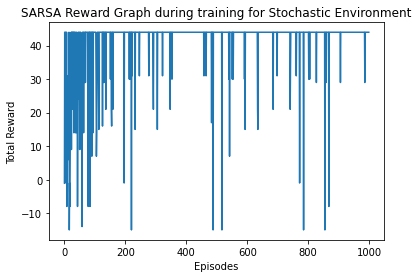

In [60]:
'''plotting graph for total_reward'''
basic_sarsa_S_ENV.plot_graph(basic_sarsa_S_ENV.games_reward, x_label="Episodes",
                           y_label = "Total Reward", title = "SARSA Reward Graph during training for Stochastic Environment")


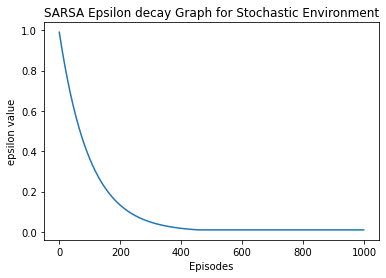

In [61]:
'''plotting graph for epsilon decay'''
basic_sarsa_S_ENV.plot_graph(basic_sarsa_S_ENV.decay_growth, x_label="Episodes",
                           y_label = "epsilon value", title = "SARSA Epsilon decay Graph for Stochastic Environment")


In [62]:
'''Evaluating the model'''
basic_sarsa_S_ENV.evaluate_model(15)

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

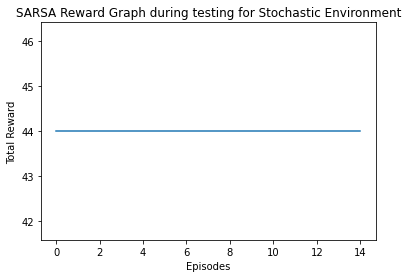

In [63]:
'''plotting graph for test games reward'''
basic_sarsa_S_ENV.plot_graph(basic_sarsa_S_ENV.evaluation_results, x_label="Episodes", 
                           y_label = "Total Reward", title="SARSA Reward Graph during testing for Stochastic Environment")


##Hyper Parameter Tuning

####HyperParameter-1 : Discount factor
Discount factor 1 : 0.2

Discount factor 2 : 0.3

Discount factor 3 : 0.4

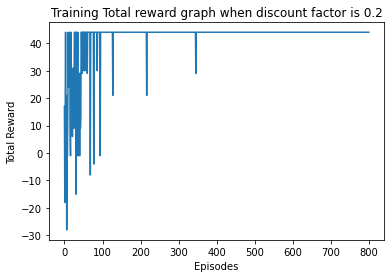

In [64]:
Deterministic_QL_env_HP1_V1 = LawnMowerDeterministicEnvironment(max_steps=30)
basic_QL_D_ENV_HP1_V1 = Q_Learning(Deterministic_QL_env_HP1_V1, learning_rate=0.1, n_episodes=800, epsilon=1, discount_factor=0.2, epsilon_decay=0.01)

basic_QL_D_ENV_HP1_V1.train_Model()

'''plotting graph for total_reward'''
basic_QL_D_ENV_HP1_V1.plot_graph(basic_QL_D_ENV_HP1_V1.games_reward, x_label="Episodes",
                           y_label = "Total Reward", title = "Training Total reward graph when discount factor is 0.2")



In [ ]:
'''Evaluating the model'''
basic_QL_D_ENV_HP1_V1.evaluate_model(15)



""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
'''plotting graph for test games reward'''
basic_QL_D_ENV_HP1_V1.plot_graph(basic_QL_D_ENV_HP1_V1.evaluation_results, x_label="Episodes", 
                           y_label = "Total Reward", title="Testing Total reward graph when discount factor is 0.2")


In [ ]:
Deterministic_QL_env_HP1_V2 = LawnMowerDeterministicEnvironment(max_steps=30)
basic_QL_D_ENV_HP1_V2 = Q_Learning(Deterministic_QL_env_HP1_V2, learning_rate=0.1, n_episodes=800, epsilon=1, discount_factor=0.3, epsilon_decay=0.01)

basic_QL_D_ENV_HP1_V2.train_Model()

'''plotting graph for total_reward'''
basic_QL_D_ENV_HP1_V2.plot_graph(basic_QL_D_ENV_HP1_V2.games_reward, x_label="Episodes",
                           y_label = "Total Reward", title = "Training Total reward graph when discount factor is 0.3")



In [ ]:
'''Evaluating the model'''
basic_QL_D_ENV_HP1_V2.evaluate_model(15)



In [ ]:
'''plotting graph for test games reward'''
basic_QL_D_ENV_HP1_V2.plot_graph(basic_QL_D_ENV_HP1_V2.evaluation_results, x_label="Episodes", 
                           y_label = "Total Reward", title="Testing Total reward graph when discount factor is 0.3")


In [ ]:
Deterministic_QL_env_HP1_V3 = LawnMowerDeterministicEnvironment(max_steps=30)
basic_QL_D_ENV_HP1_V3 = Q_Learning(Deterministic_QL_env_HP1_V3, learning_rate=0.1, n_episodes=800, epsilon=1, discount_factor=0.4, epsilon_decay=0.01)

basic_QL_D_ENV_HP1_V3.train_Model()

'''plotting graph for total_reward'''
basic_QL_D_ENV_HP1_V3.plot_graph(basic_QL_D_ENV_HP1_V3.games_reward, x_label="Episodes",
                           y_label = "Total Reward", title = "Training Total reward graph when discount factor is 0.4")



In [ ]:
'''Evaluating the model'''
basic_QL_D_ENV_HP1_V3.evaluate_model(15)



In [ ]:
'''plotting graph for test games reward'''
basic_QL_D_ENV_HP1_V3.plot_graph(basic_QL_D_ENV_HP1_V3.evaluation_results, x_label="Episodes", 
                           y_label = "Total Reward", title="Testing Total reward graph when discount factor is 0.4")


####HyperParameter-2 : Max timesteps
Max timesteps 1 : 20

Max timesteps 2 : 25

Max timesteps 3 : 30

In [ ]:
Deterministic_QL_env_HP2_V1 = LawnMowerDeterministicEnvironment(max_steps=20)
basic_QL_D_ENV_HP2_V1 = Q_Learning(Deterministic_QL_env_HP2_V1, learning_rate=0.1, n_episodes=800, epsilon=1, discount_factor=0.3, epsilon_decay=0.01)

basic_QL_D_ENV_HP2_V1.train_Model()

'''plotting graph for total_reward'''
basic_QL_D_ENV_HP2_V1.plot_graph(basic_QL_D_ENV_HP2_V1.games_reward, x_label="Episodes",
                           y_label = "Total Reward", title = "Training Total reward graph when maxtimestep is 20")



In [ ]:
'''Evaluating the model'''
basic_QL_D_ENV_HP2_V1.evaluate_model(15)



In [ ]:
'''plotting graph for test games reward'''
basic_QL_D_ENV_HP2_V1.plot_graph(basic_QL_D_ENV_HP2_V1.evaluation_results, x_label="Episodes", 
                           y_label = "Total Reward", title="Testing Total reward graph when maxtimestep is 20")


In [ ]:
Deterministic_QL_env_HP2_V2 = LawnMowerDeterministicEnvironment(max_steps=25)
basic_QL_D_ENV_HP2_V2 = Q_Learning(Deterministic_QL_env_HP2_V2, learning_rate=0.1, n_episodes=800, epsilon=1, discount_factor=0.3, epsilon_decay=0.01)

basic_QL_D_ENV_HP2_V2.train_Model()

'''plotting graph for total_reward'''
basic_QL_D_ENV_HP2_V2.plot_graph(basic_QL_D_ENV_HP2_V2.games_reward, x_label="Episodes",
                           y_label = "Total Reward", title = "Training Total reward graph when maxtimestep is 25")



In [ ]:
'''Evaluating the model'''
basic_QL_D_ENV_HP2_V2.evaluate_model(15)



In [ ]:
'''plotting graph for test games reward'''
basic_QL_D_ENV_HP2_V2.plot_graph(basic_QL_D_ENV_HP2_V2.evaluation_results, x_label="Episodes", 
                           y_label = "Total Reward", title="Testing Total reward graph when maxtimestep is 25")


In [ ]:
Deterministic_QL_env_HP2_V3 = LawnMowerDeterministicEnvironment(max_steps=30)
basic_QL_D_ENV_HP2_V3 = Q_Learning(Deterministic_QL_env_HP2_V3, learning_rate=0.1, n_episodes=800, epsilon=1, discount_factor=0.3, epsilon_decay=0.01)

basic_QL_D_ENV_HP2_V3.train_Model()

'''plotting graph for total_reward'''
basic_QL_D_ENV_HP2_V3.plot_graph(basic_QL_D_ENV_HP2_V3.games_reward, x_label="Episodes",
                           y_label = "Total Reward", title = "Training Total reward graph when maxtimestep is 30")



In [ ]:
'''Evaluating the model'''
basic_QL_D_ENV_HP2_V3.evaluate_model(15)



In [ ]:
'''plotting graph for test games reward'''
basic_QL_D_ENV_HP2_V3.plot_graph(basic_QL_D_ENV_HP2_V3.evaluation_results, x_label="Episodes", 
                           y_label = "Total Reward", title="Testing Total reward graph when maxtimestep is 30")


#Part - 3

In [ ]:
# Imports
!pip install gymnasium
import gymnasium
from gymnasium import spaces
import math
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Defining the Stock Trading Environment.
"""DON'T MAKE ANY CHANGES TO THE ENVIRONMENT."""


class StockTradingEnvironment(gymnasium.Env):
    """This class implements the Stock Trading environment."""

    def __init__(self, file_path, train=True, number_of_days_to_consider=10):
        """This method initializes the environment.

        :param file_path: - Path of the CSV file containing the historical stock data.
        :param train: - Boolean indicating whether the goal is to train or test the performance of the agent.
        :param number_of_days_to_consider = Integer representing the number of days the for which the agent
                considers the trend in stock price to make a decision."""

        self.file_path = file_path
        self.stock_data = pd.read_csv(self.file_path)
        self.train = train


        # Splitting the data into train and test datasets.
        self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
        self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()

        self.observation_space = spaces.Discrete(4)
        self.action_space = spaces.Discrete(3)

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # This defines the number of days for which the agent considers the data before taking an action.
        self.number_of_days_to_consider = number_of_days_to_consider
        # The maximum timesteps the agent will take before the episode ends.
        if self.train:
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider
        else:
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider
        # Initializing the number of steps taken to 0.
        self.timestep = 0
        self.reset()

    def reset(self):
        """This method resets the environment and returns the observation.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.

                 info: - info: - A dictionary that can be used to provide additional implementation information."""

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # Initializing the number of steps taken to 0.
        self.timestep = 0

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector that will be passed to the agent.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector.
            observation = [price_increase, stock_held]

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        info = None

        return observation, info

    def step(self, action):
        """This method implements what happens when the agent takes the action to Buy/Sell/Hold.

        :param action: - Integer in the range 0 to 2 inclusive.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.
                 reward: - Integer/Float value that's used to measure the performance of the agent.
                 terminated: - Boolean describing whether the episode has terminated.
                 truncated: - Boolean describing whether a truncation condition outside the scope of the MDP is satisfied.
                 info: - A dictionary that can be used to provide additional implementation information."""

        # We give the agent a penalty for taking actions such as buying a stock when the agent doesn't have the
        # investment capital and selling a stock when the agent doesn't have any shares.
        penalty = 0

        if self.train:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.training_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value +=\
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider]\
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        else:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.testing_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = self.training_stock_data['Open'][
                                           self.timestep + self.number_of_days_to_consider] * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        # Determining if the agent currently has shares of the stock or not.
        if self.number_of_shares > 0:
            stock_held = True
        else:
            stock_held = False

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        self.timestep += 1  # Increasing the number of steps taken by the agent by 1.

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        # Computing the total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # Appending the total account value of the list to plot the graph.
        self.total_account_value_list.append(self.total_account_value)

        # The episode terminates when the maximum timesteps have been reached.
        terminated = True if (self.timestep >= self.max_timesteps) \
            else False
        truncated = False
        info = {}

        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        """This method renders the agent's total account value over time.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""

        plt.figure(figsize=(15, 10))
        plt.plot(self.total_account_value_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Total Account Value', fontsize=32)
        plt.title('Total Account Value over Time', fontsize=38)
        plt.grid()
        plt.show()

In [ ]:
class Q_Learning_Stock_Trading():
  def __init__(self, environment = StockTradingEnvironment('NVDA.csv', number_of_days_to_consider=10),learning_rate = 0.01, n_episodes = 1500, epsilon = 1.0, discount_factor = 0.3, epsilon_decay = 0.01):
    self.alpha = learning_rate
    self.n_episodes = n_episodes
    self.epsilon = epsilon
    self.gamma = discount_factor
    self.epsilon_decay = epsilon_decay
    self.env = environment
    self.state_count = self.env.observation_space.n
    
    self.Q_Table = np.random.random((self.state_count, self.env.action_space.n))
    self.Q_Table[self.env.observation_space.n - 1,:] = 0
    
    self.games_reward = []
    self.closing_account_value = []
    self.decay_growth = []
    self.evaluation_results = []
    pass
  def plot_graph(self, data=None, x_label="", y_label="", title=""):
    if data is None:
      print("There isn't any data to plot")
      return 
    print("\n")
    plt.plot(data)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    pass
  def greedy(self, cur_state):
    return np.argmax(self.Q_Table[cur_state])
  
  def epsilon_greedy(self, cur_state):
    '''Epsilon greedy policy'''

    if np.random.uniform(0,1) < self.epsilon:
        return self.env.action_space.sample()
    else:
        return self.greedy(cur_state)
  
  def greedy_table(self, cur_state):
    return np.argmax(self.Q_Table[cur_state])
  
  def train_Model(self):
    for episode in range(self.n_episodes):
      obs, info = self.env.reset()
      state = obs
      done = False
      tot_rew = 0
      
      self.epsilon = max(0.01, self.epsilon - (self.epsilon * self.epsilon_decay))
      action = self.epsilon_greedy(state) 
      
      while not done:
        observation, rew, done, truncated, _ = self.env.step(action)
        next_state = observation
        next_action = self.epsilon_greedy(next_state)
        gamma_multiplier = self.Q_Table[next_state][self.greedy_table(next_action)]
        self.Q_Table[state][action] = self.Q_Table[state][action] + self.alpha * (rew +
                                                                                     self.gamma * gamma_multiplier -
                                                                                     self.Q_Table[state][action])
        state = next_state
        action = next_action
        tot_rew += rew

        if done:
          self.games_reward.append(tot_rew)
          self.closing_account_value.append(self.env.total_account_value_list[-1])
          self.decay_growth.append(self.epsilon)
  def evaluate_model(self, test_n_episodes = 10):
    output_grid = widgets.Grid(1,1)
    for ep in range(test_n_episodes):
      self.env.train = False
      obs, info = self.env.reset()
      state = obs
      done = False
      tot_rew = 0
      while not done:
        action = self.greedy(state)
        observation, rew, done, truncated, _ = self.env.step(action)
        state = observation

        tot_rew += rew
        if done:
          self.evaluation_results.append(tot_rew)
      with output_grid.output_to(0,0):
          self.env.render()
          time.sleep(0.2)
          #output_grid.clear_cell()
    pass
    


In [ ]:

QL_ST_env = StockTradingEnvironment('NVDA.csv', number_of_days_to_consider=10)
basic_QL_ST_obj = Q_Learning_Stock_Trading(QL_ST_env, learning_rate=0.15, n_episodes=500, epsilon=1, discount_factor=0.2, epsilon_decay=0.01)
print("\nInitial Q Table with random Values")
print(basic_QL_ST_obj.Q_Table)


In [ ]:
'''Preparing the Q tables For Q learning algorithm'''

basic_QL_ST_obj.train_Model()


In [ ]:
'''Printing final Q tables obtained after running Q-learning algorithm'''
print("\nFinal Q Table Values")
print(basic_QL_ST_obj.Q_Table)

with open('Stock_trading_q_table_values.pickle', 'wb') as handle:
    pickle.dump(basic_QL_ST_obj.Q_Table, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
'''plotting graph for total_reward'''
basic_QL_ST_obj.plot_graph(basic_QL_ST_obj.games_reward, x_label="Episodes",
                           y_label = "Total Reward", title = "Q learning Reward Graph")


In [ ]:

'''plotting graph for epsilon decay'''
basic_QL_ST_obj.plot_graph(basic_QL_ST_obj.decay_growth, x_label="Episodes",
                           y_label = "epsilon value", title = "Q learning Epsilon Decay Graph")


In [ ]:
QL_ST_env.render()

In [ ]:
'''Evaluating the environment'''

basic_QL_ST_obj.evaluate_model()

In [ ]:
'''plotting graph for test games reward'''
basic_QL_ST_obj.plot_graph(basic_QL_ST_obj.evaluation_results, x_label="Episodes", 
                           y_label = "Total Reward", title="Q learning Reward Graph during Testing")
